In [184]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
import jax.tree_util as jtu
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from scipy.stats import pearsonr, spearmanr
from collections import defaultdict
from utils import calc_zscores, plot_heatmaps_by_knockout_ordered, filter_deg_optimized, calculate_similarities
from functools import partial

cmap = sns.color_palette("coolwarm", as_cmap=True)
cell_line_order = ['HAP1', 'K562', 'A549', 'HT29', 'MCF7', 'BXPC3', 'BXPC3 (predicted)']

In [185]:
def calc_zscores_limited_nr_cells(sample1, sample2, limit_sample_1, limit_sample_2):
    if issparse(sample1):
        sample1 = sample1.toarray()
    if issparse(sample2):
        sample2 = sample2.toarray()

    # limit_sample_1 = np.min(limit_sample_1, sample1.shape[0])
    # limit_sample_2 = np.min(limit_sample_2, sample2.shape[0])
    sample1 = sample1[limit_sample_1,:]
    sample2 = sample2[limit_sample_2,:]

    mean1 = sample1.mean(axis=0)
    std1 = sample1.std(axis=0)
    mean2 = sample2.mean(axis=0)
    std2 = sample2.std(axis=0)
    
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    se = np.sqrt((std1**2 / n1) + (std2**2 / n2))
    
    z_scores = (mean1 - mean2) / se
    return z_scores

In [186]:
predictions_path = '/lustre/groups/ml01/workspace/alessandro.palma/ot_pert/out/results_metrics/generated_data/sweep_cell_line_pathway/adata_ood_split_BXPC3_IFNG.h5ad'
train_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/BXPC3_IFNG/adata_train_BXPC3_IFNG.h5ad'
test_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type/BXPC3_IFNG/adata_test_BXPC3_IFNG.h5ad'
ood_path = '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/adata_ood_final_pathway_cell_type_full_source/BXPC3_IFNG/adata_ood_BXPC3_IFNG.h5ad'

In [187]:
predictions = sc.read_h5ad(predictions_path)
train = sc.read_h5ad(train_path)
test = sc.read_h5ad(test_path)
ood = sc.read_h5ad(ood_path)

# generate dicts for jtu tree_map
ood_target = ood[ood.obs['gene'] != 'NT', :]
ood_source = ood[ood.obs['gene'] == 'NT', :]
ood_target_dict = {c: ood_target[ood_target.obs['condition'] == c, :].X for c in ood_target.obs['condition'].unique()}
ood_source_dict = {c: ood_source[ood_source.obs['pathway'] == c.split('_')[1], :].X for c in ood_target.obs['condition'].unique()}
ood_prediction = {c: predictions[predictions.obs['condition'] == c].layers['X_recon_pred'] for c in predictions.obs['condition'].unique()}

train = ad.concat([train, test])
train_target = train[train.obs['gene'] != 'NT', :]
train_source = train[train.obs['gene'] == 'NT', :]
train_target_dict = {c: train_target[train_target.obs['condition'] == c, :].X for c in train_target.obs['condition'].unique()}
train_source_dict = {c: train_source[train_source.obs['pathway'] == c.split('_')[1], :].X for c in train_target.obs['condition'].unique()}

In [188]:
ood_zscores = jtu.tree_map(calc_zscores, ood_target_dict, ood_source_dict)
prediction_zscores = jtu.tree_map(calc_zscores, ood_prediction, ood_source_dict)
train_zscores = jtu.tree_map(calc_zscores, train_target_dict, train_source_dict)

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:28: RuntimeWarning: invalid value encountered in divide
  z_scores = (mean1 - mean2) / se


In [189]:
df_train = []
for key, value in train_zscores.items():
    df_train.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(train.var_names),
        'zscore': value
    }))
df_train = pd.concat(df_train)

df_ood = []
for key, value in ood_zscores.items():
    df_ood.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_ood = pd.concat(df_ood)

df_prediction = []
for key, value in prediction_zscores.items():
    df_prediction.append(pd.DataFrame({
        'predicted': True,
        'cell_line': key.split('_')[0] + ' (predicted)',
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_predicted = pd.concat(df_prediction)
df_predicted_filtered = df_predicted[df_predicted['zscore'].notna()]

df_ground_truth = pd.concat([df_train, df_ood])
df_ground_truth_filtered = df_ground_truth[df_ground_truth['zscore'].notna()]

df_zscores = pd.concat([df_ground_truth, df_predicted])

In [190]:
perturbation_programs = pd.read_csv('./table3_programs.csv')

In [191]:
present_in_BXPC3 = perturbation_programs.query('cellline == "BXPC3" and pathway == "IFNG"')[['pathway', 'program', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = set(zip(present_in_BXPC3['gene'], present_in_BXPC3['perturbation'], present_in_BXPC3['pathway'], present_in_BXPC3['program']))

filtered_df = perturbation_programs[
    perturbation_programs[['gene', 'perturbation', 'pathway', 'program']].apply(tuple, axis=1).isin(valid_combinations)
]

cell_line_counts = (
    filtered_df.groupby(['gene', 'pathway', 'perturbation', 'program'])['cellline']
    .nunique()
    .reset_index(name='cellline_count')
)

valid_combinations = cell_line_counts[cell_line_counts['cellline_count'] >= 6] # TODO: should we choose another threshold?

df_present_in_all_ct = filtered_df.merge(valid_combinations[['gene', 'pathway', 'perturbation', 'program']], 
                                on=['gene', 'pathway', 'perturbation', 'program'], 
                                how='inner')
df_present_in_all_ct = df_present_in_all_ct.drop(columns=['Unnamed: 0'])

In [192]:
df_present_in_all_ct['program'].value_counts()

program
IFNG_program1_up      9000
IFNG_program1_down    9000
Name: count, dtype: int64

## program 1

In [200]:
IFNG_program1 = df_present_in_all_ct.query('program =="IFNG_program1_up" or program == "IFNG_program1_down"')
IFNG_program1 = IFNG_program1.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline'])
df_selected = df_zscores.merge(IFNG_program1, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


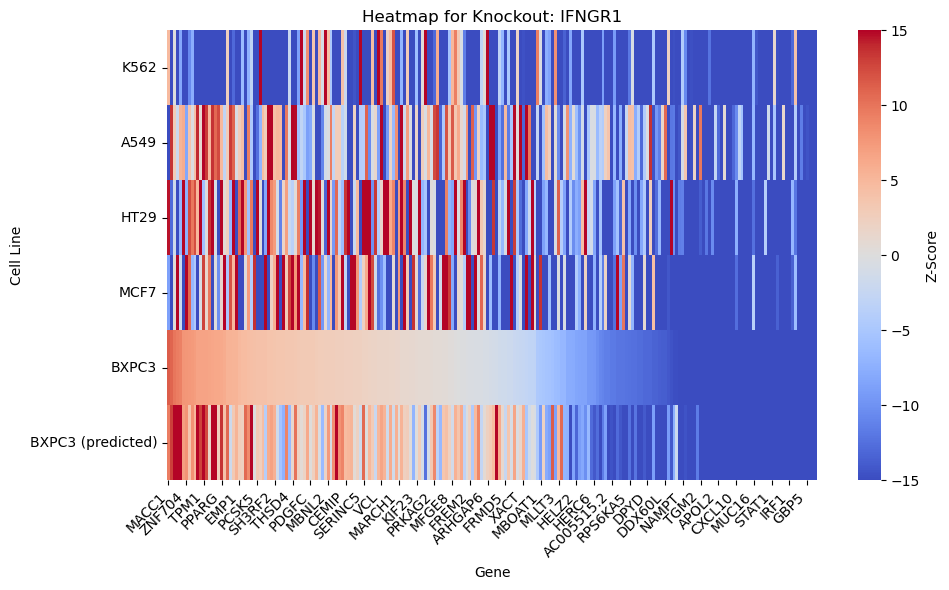

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


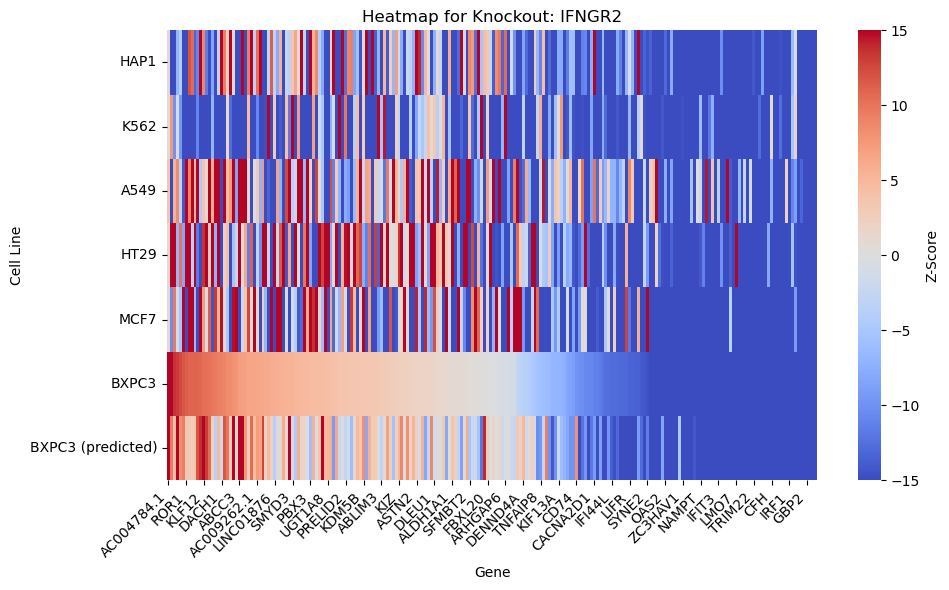

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


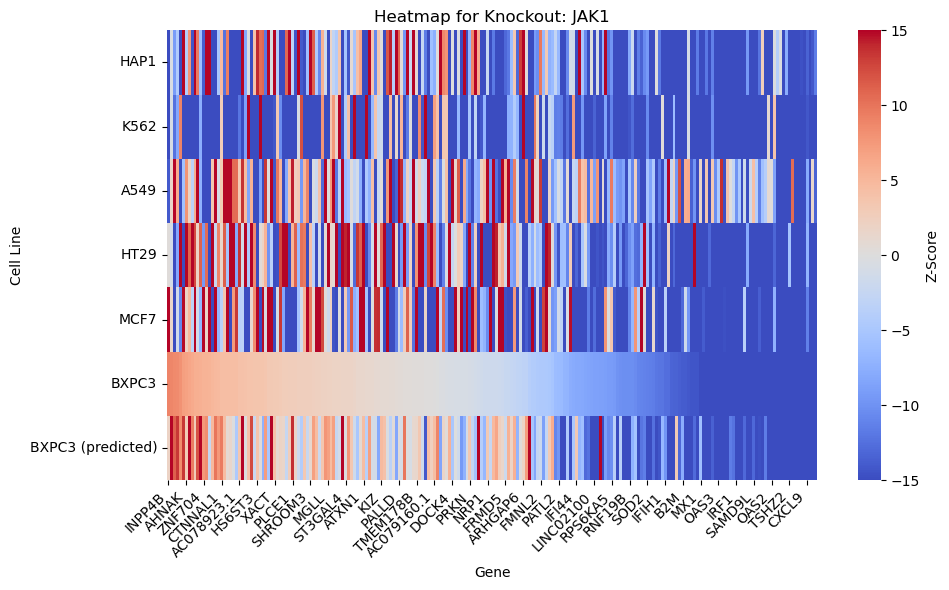

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


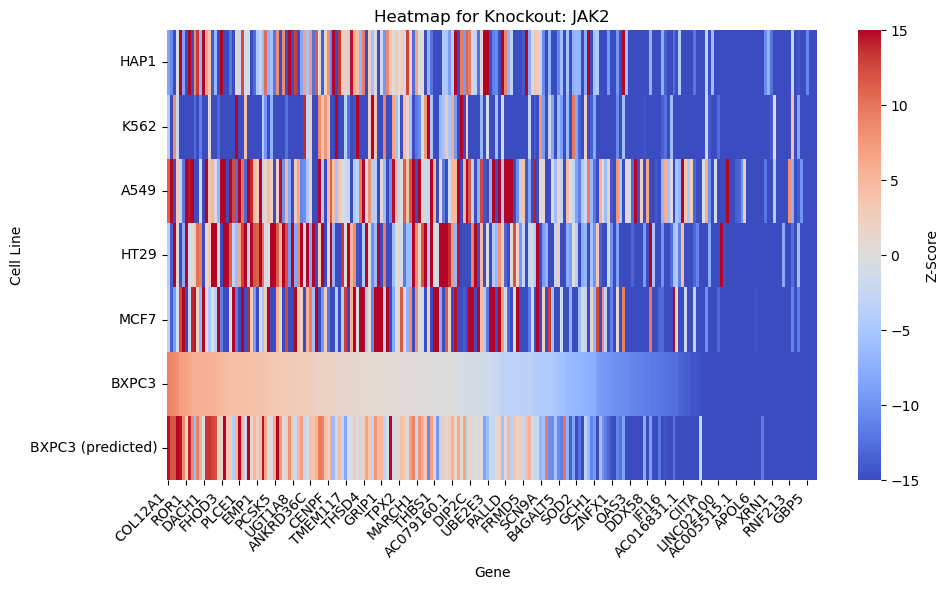

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


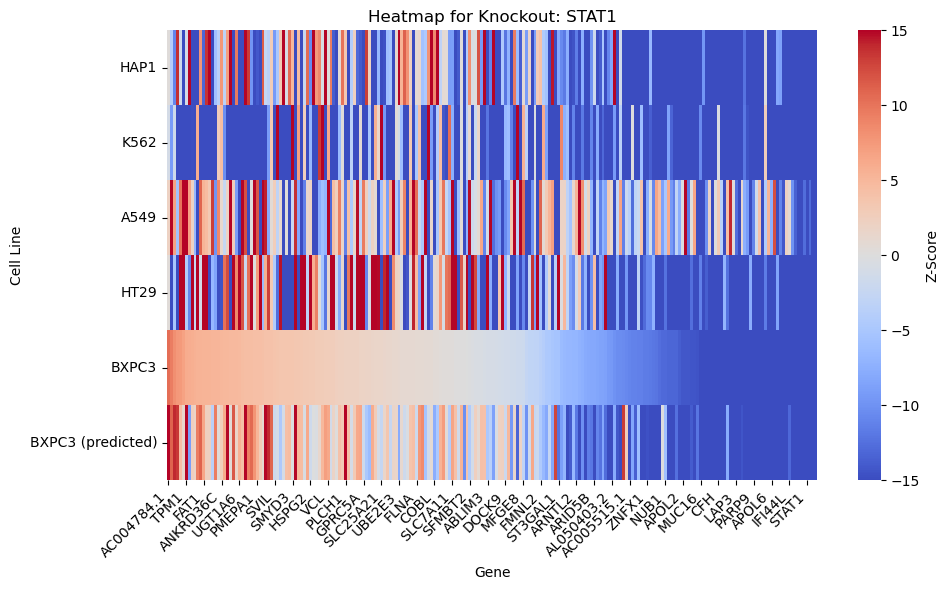

In [201]:
plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [202]:
df_selected = df_selected.drop(columns=['cell_line', 'zscore', 'program'])
df_predicted_heatmaps = df_predicted_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.359019              0.349592   
1   BXPC3 (predicted)      HAP1             0.390602              0.397691   
2   BXPC3 (predicted)      HT29             0.489989              0.558404   
3   BXPC3 (predicted)      K562             0.222574              0.170841   
4   BXPC3 (predicted)      MCF7             0.412167              0.423035   
5   BXPC3 (predicted)     BXPC3             0.889099              0.840050   

         MAE  
0  14.919915  
1  16.856281  
2  14.997198  
3  23.490984  
4  18.532595  
5   6.658049

## program 2

In [253]:
program2 = perturbation_programs.query('program =="IFNG_program2_up" or program == "IFNG_program2_down"')[['pathway', 'program', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = set(zip(program2['gene'], program2['perturbation'], program2['pathway'], program2['program']))

program2_df = perturbation_programs[
    perturbation_programs[['gene', 'perturbation', 'pathway', 'program']].apply(tuple, axis=1).isin(valid_combinations)
]

In [254]:
program2_df

Unnamed: 0 pathway             program      gene cellline perturbation
51914           2    IFNG    IFNG_program2_up       CFH     A549         IRF1
51915           2    IFNG    IFNG_program2_up     CXCL9     A549         IRF1
51916           2    IFNG    IFNG_program2_up     THBS1     A549         IRF1
51917           2    IFNG    IFNG_program2_up   DENND4A     A549         IRF1
51918           2    IFNG    IFNG_program2_up       ST5     A549         IRF1
...           ...     ...                 ...       ...      ...          ...
53201           3    IFNG  IFNG_program2_down  ANKRD18B     HT29         IRF1
53202           3    IFNG  IFNG_program2_down    CADPS2     HT29         IRF1
53203           3    IFNG  IFNG_program2_down      GBP5     HT29         IRF1
53204           3    IFNG  IFNG_program2_down      NTN4     HT29         IRF1
53205           3    IFNG  IFNG_program2_down     UMAD1     HT29         IRF1

[1292 rows x 6 columns]

In [255]:
program2_df = program2_df.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline', 'Unnamed: 0', 'program'])
df_selected = df_zscores.merge(program2_df, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

In [256]:
df_selected['cell_line_orig'] = df_selected['cell_line']
df_selected['cell_line'] = df_selected['cell_line'] + ' (' + df_selected['knockout'] + ')'
df_selected['knockout'] = 'IFNG program 2'

In [257]:
cell_line_order = ['A549 (IRF1)', 'HAP1 (IRF1)', 'HT29 (IRF1)', 'MCF7 (IRF1)',
        'BXPC3 (IRF2)',
       'BXPC3 (predicted) (IRF2)']

vmin=-15
vmax=15

In [258]:
df = df_selected
df = df[df['cell_line'].isin(cell_line_order)]

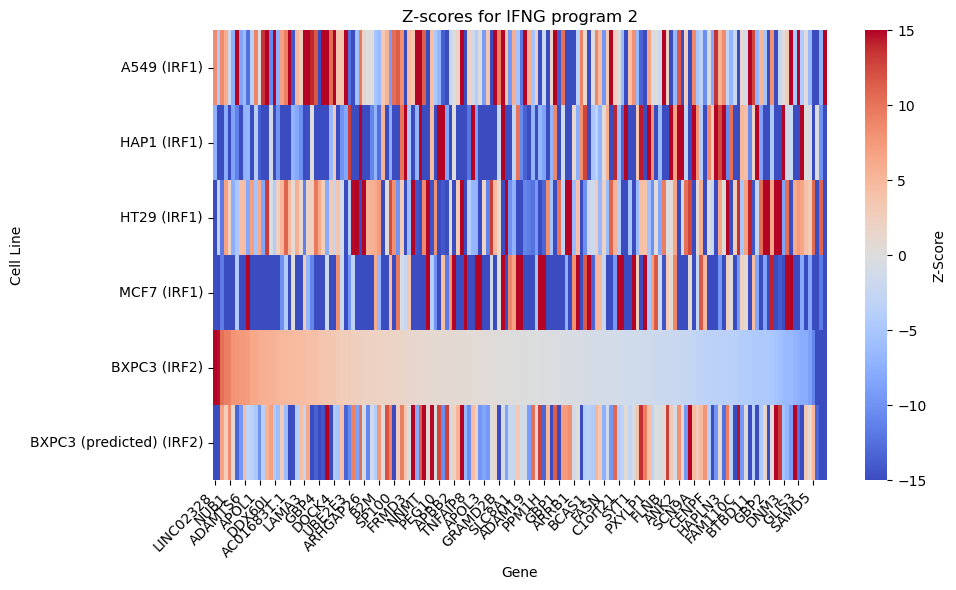

In [245]:
knockouts = df['knockout'].unique()
for knockout in knockouts:
    knockout_df = df[df['knockout'] == knockout]

    # Order cell lines
    if cell_line_order is not None:
        knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)
        knockout_df = knockout_df.sort_values('cell_line')
    
    # Determine gene order by z-scores in the BXPC3 cell line
    bxpc3_genes = knockout_df[knockout_df['cell_line'] == 'BXPC3 (IRF2)'][['gene', 'zscore']].dropna()
    gene_order = bxpc3_genes.sort_values('zscore', ascending=False)['gene'].tolist()

    # Pivot the data
    heatmap_data = knockout_df.pivot(index='cell_line', columns='gene', values='zscore')

    # Reorder the columns (genes) by BXPC3 z-scores
    heatmap_data = heatmap_data[gene_order]

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm',
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Z-Score'}
    )
    plt.title(f"Z-scores for {knockout}")
    plt.xlabel("Gene")
    plt.ylabel("Cell Line")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [260]:
df_selected['cell_line'] = df_selected['cell_line_orig']

In [266]:
df_selected_pred = df_selected[df_selected['predicted']]
df_selected_gt = df_selected[df_selected['predicted']==False]

In [267]:
df_results_heatmaps = calculate_similarities(df_selected_pred, df_selected_gt)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549            -0.067459             -0.135088   
1   BXPC3 (predicted)      HAP1            -0.055190             -0.001148   
2   BXPC3 (predicted)      HT29             0.015039              0.043731   
3   BXPC3 (predicted)      MCF7             0.108620              0.092284   
4   BXPC3 (predicted)     BXPC3             0.156375              0.099586   

         MAE  
0  17.866005  
1  21.521236  
2  15.710122  
3  22.507637  
4  11.030851

## perturbation program 1 up and down regulation

In [55]:
IFNG_program1_up = df_present_in_all_ct.loc[df_present_in_all_ct['program'] == 'IFNG_program1_up']
IFNG_program1_up = IFNG_program1_up.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline'])
df_selected = df_zscores.merge(IFNG_program1_up, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


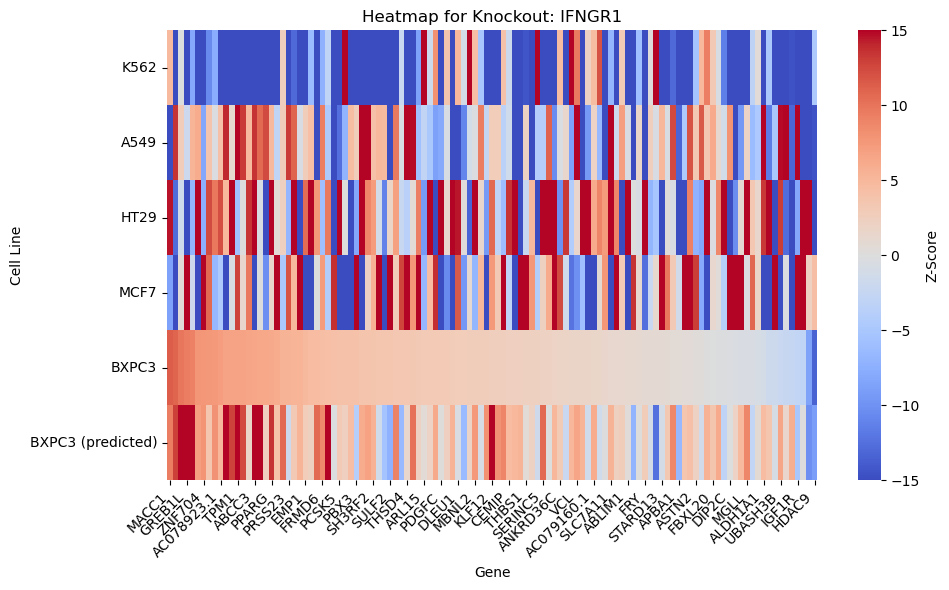

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


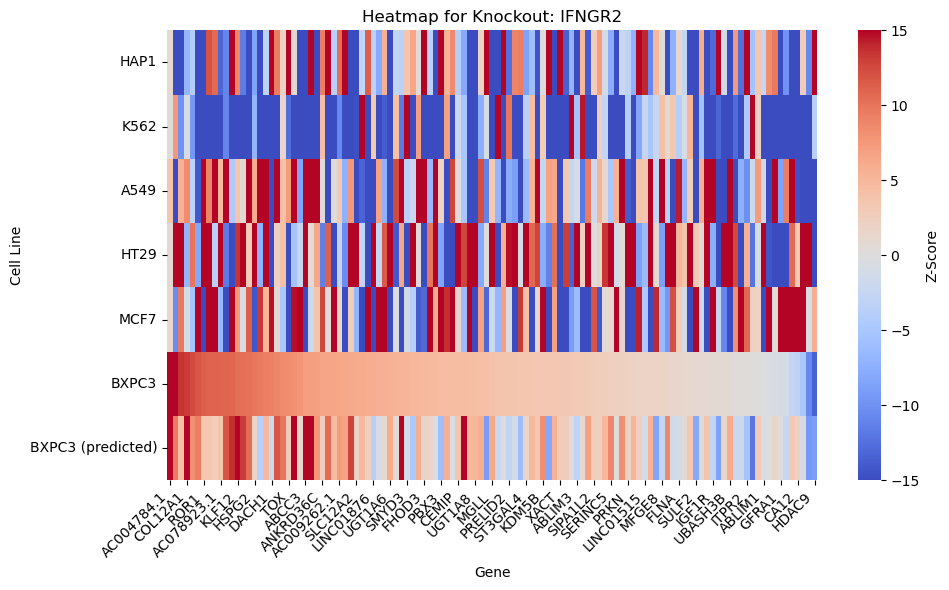

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


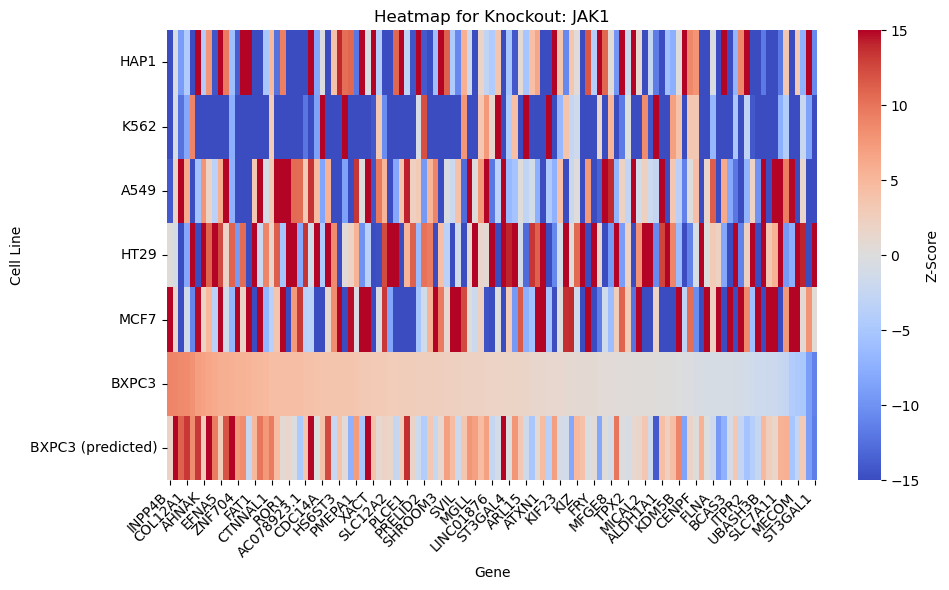

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


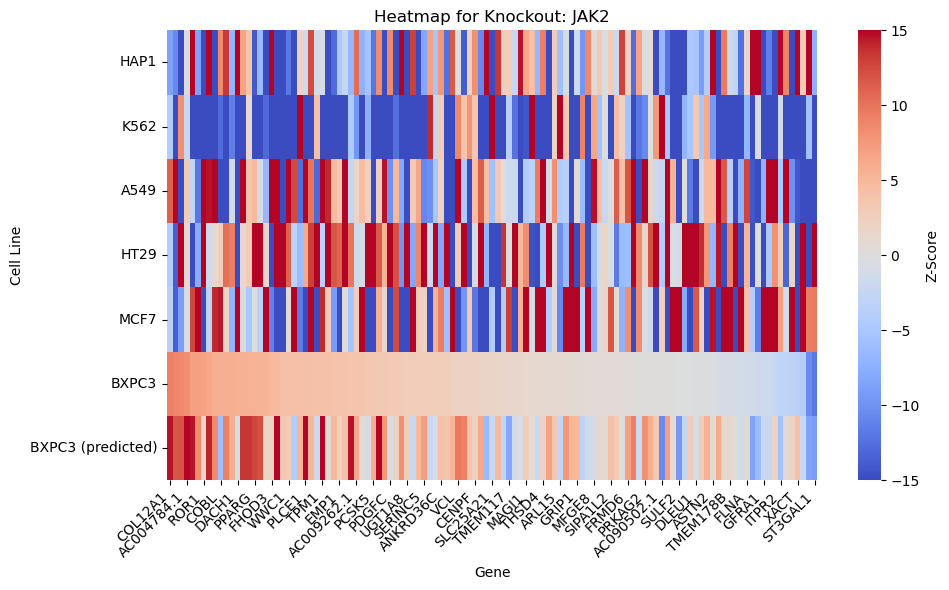

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


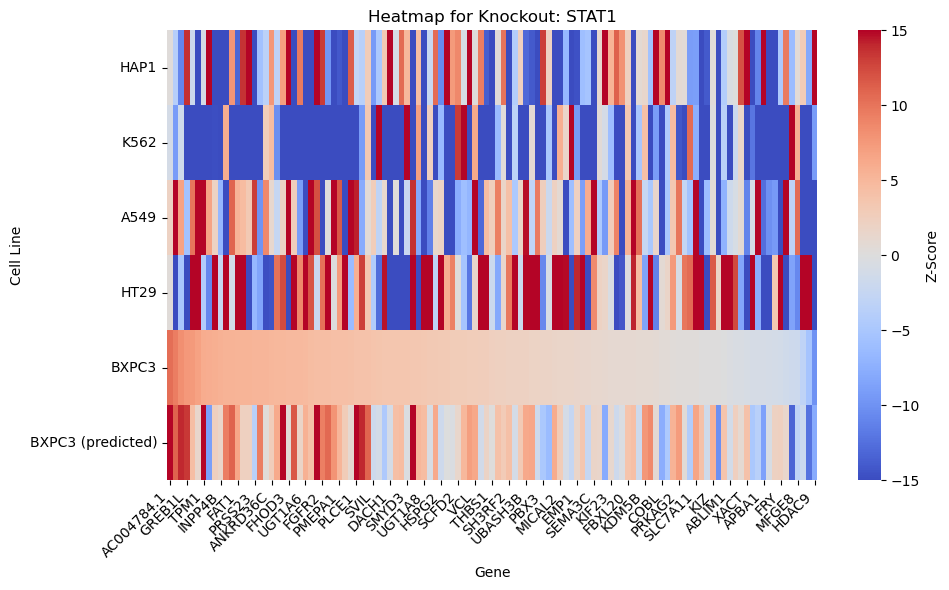

In [58]:
plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [73]:
df_selected = df_selected.drop(columns=['cell_line', 'zscore', 'program'])
df_predicted_heatmaps = df_predicted_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.284232              0.278451   
1   BXPC3 (predicted)      HAP1            -0.144613             -0.144851   
2   BXPC3 (predicted)      HT29             0.153677              0.181016   
3   BXPC3 (predicted)      K562            -0.101836             -0.060912   
4   BXPC3 (predicted)      MCF7            -0.189915             -0.200416   
5   BXPC3 (predicted)     BXPC3             0.522449              0.462206   

         MAE  
0  12.083160  
1  16.442991  
2  14.641271  
3  24.935282  
4  19.492132  
5   4.259105

In [74]:
df_program = df_present_in_all_ct.loc[df_present_in_all_ct['program'] == 'IFNG_program1_down']
df_program = df_program.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline'])
df_selected = df_zscores.merge(df_program, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


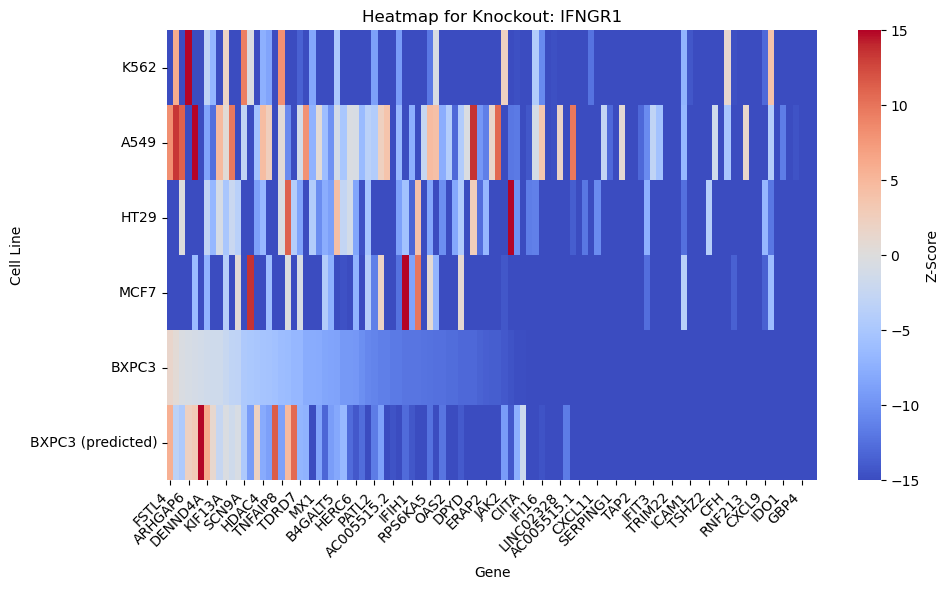

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


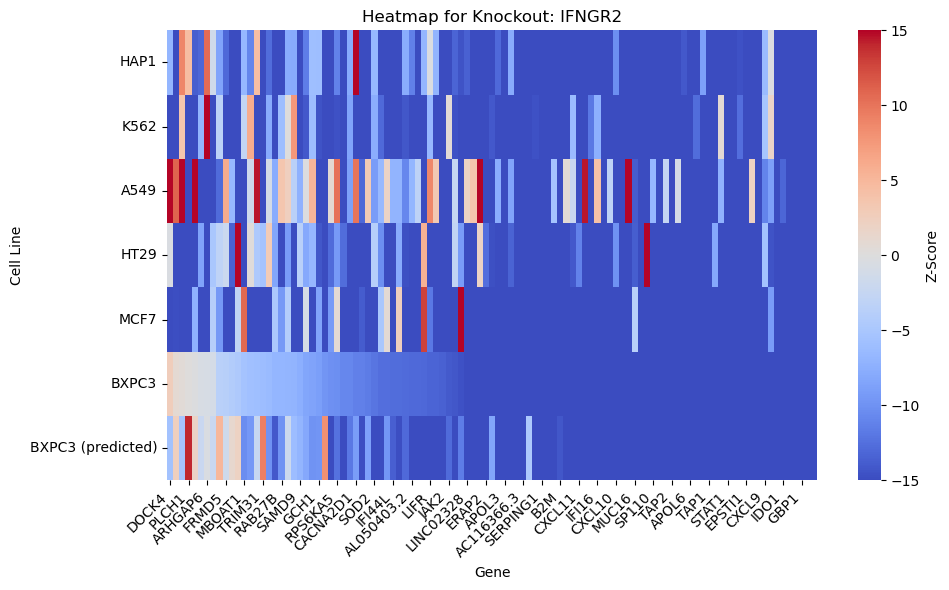

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


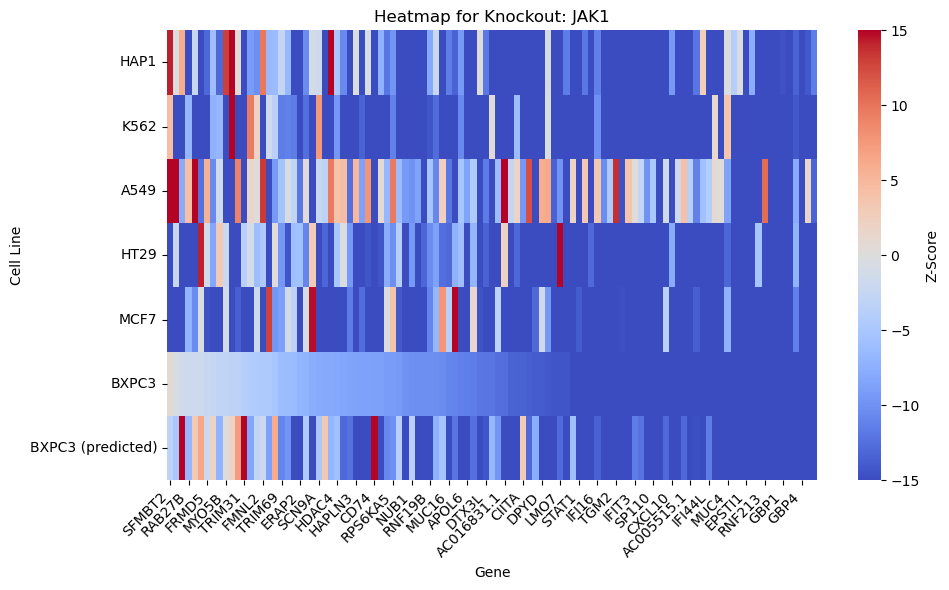

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


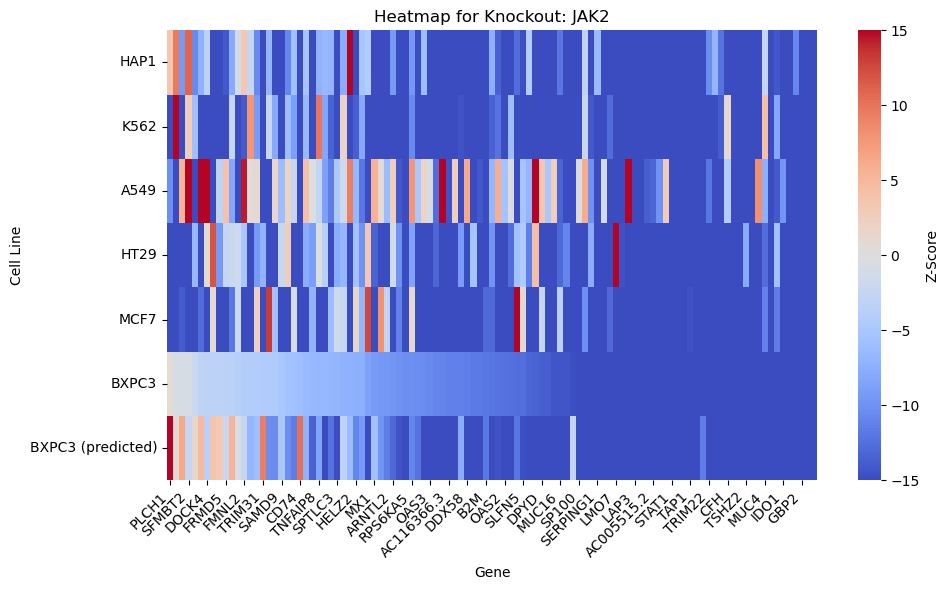

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


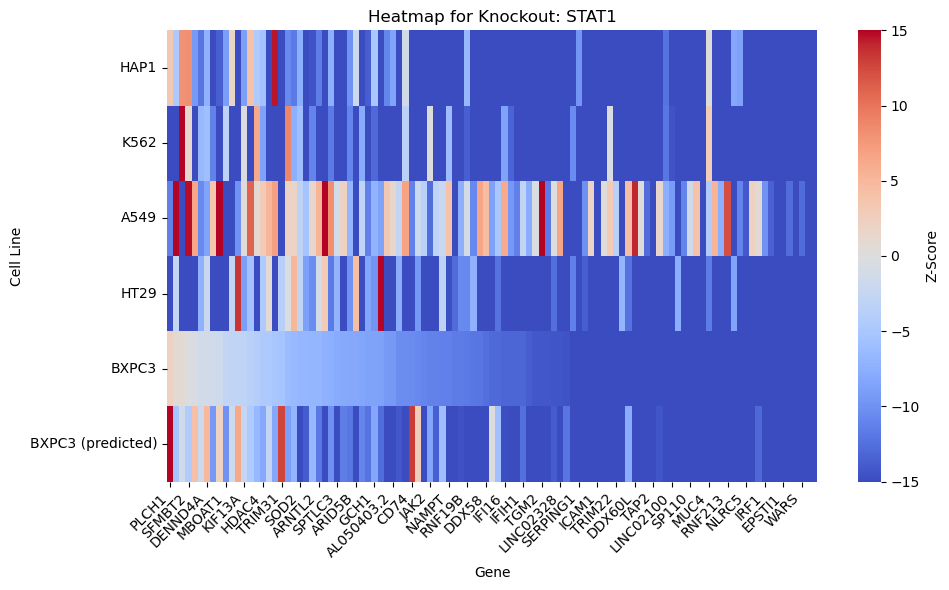

In [75]:
plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [76]:
df_selected = df_selected.drop(columns=['cell_line', 'zscore', 'program'])
df_predicted_heatmaps = df_predicted_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.312169              0.312347   
1   BXPC3 (predicted)      HAP1             0.273954              0.366151   
2   BXPC3 (predicted)      HT29             0.271283              0.323289   
3   BXPC3 (predicted)      K562             0.136814              0.152376   
4   BXPC3 (predicted)      MCF7             0.332898              0.313646   
5   BXPC3 (predicted)     BXPC3             0.849574              0.823205   

         MAE  
0  18.026834  
1  17.308931  
2  15.387024  
3  21.909136  
4  17.481674  
5   9.285463

### metrics accross both programs

In [110]:
df_present_in_all_ct

pathway             program     gene cellline perturbation
0        IFNG    IFNG_program1_up    AHNAK     A549       IFNGR1
1        IFNG    IFNG_program1_up    ASTN2     A549       IFNGR1
2        IFNG    IFNG_program1_up     TPM1     A549       IFNGR1
3        IFNG    IFNG_program1_up    MAGI1     A549       IFNGR1
4        IFNG    IFNG_program1_up    EFNA5     A549       IFNGR1
...       ...                 ...      ...      ...          ...
17995    IFNG  IFNG_program1_down  TMEM140     MCF7        STAT1
17996    IFNG  IFNG_program1_down    IFI35     MCF7        STAT1
17997    IFNG  IFNG_program1_down    DOCK4     MCF7        STAT1
17998    IFNG  IFNG_program1_down    ISG20     MCF7        STAT1
17999    IFNG  IFNG_program1_down   DNAJC1     MCF7        STAT1

[18000 rows x 5 columns]

In [112]:
df_selected = df_present_in_all_ct.drop(columns=['cellline', 'program']).rename(columns={'perturbation': 'knockout'})
df_predicted_heatmaps = df_predicted_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.356682              0.346787   
1   BXPC3 (predicted)      HAP1             0.393697              0.401893   
2   BXPC3 (predicted)      HT29             0.489304              0.557631   
3   BXPC3 (predicted)      K562             0.223669              0.171225   
4   BXPC3 (predicted)      MCF7             0.415134              0.426385   
5   BXPC3 (predicted)     BXPC3             0.888681              0.840409   

         MAE  
0  14.862349  
1  16.871572  
2  14.975745  
3  23.496279  
4  18.486975  
5   6.664983

## when selecting only a subset of cells

In [171]:
IFNG_program1_up_cond

['A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_IFNGR1',
 'A549_IFNG_I

In [174]:
IFNG_program1_up = df_present_in_all_ct.query('program == "IFNG_program1_up"')
IFNG_program1_up['cond'] = IFNG_program1_up['cellline'] + '_' + IFNG_program1_up['pathway'] + "_" + IFNG_program1_up['perturbation']
IFNG_program1_up_cond = IFNG_program1_up['cond'].unique()
IFNG_program1_source_ood = {k: v[:4747,:] for k, v in {**ood_source_dict}.items() if k in IFNG_program1_up_cond}
IFNG_program1_target_ood = {k: v[:337,:] for k, v in {**ood_target_dict}.items() if k in IFNG_program1_up_cond}
IFNG_program1_predicted_ood = {k: v[:337,:] for k, v in {**ood_prediction}.items() if k in IFNG_program1_up_cond}
IFNG_program1_source_train = {k: v[:4747,:] for k, v in {**train_source_dict}.items() if k in IFNG_program1_up_cond}
IFNG_program1_target_train = {k: v[:337,:] for k, v in {**train_target_dict}.items() if k in IFNG_program1_up_cond}

/tmp/ipykernel_3669228/731432673.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IFNG_program1_up['cond'] = IFNG_program1_up['cellline'] + '_' + IFNG_program1_up['pathway'] + "_" + IFNG_program1_up['perturbation']


In [176]:
ood_zscores = jtu.tree_map(calc_zscores, IFNG_program1_target_ood, IFNG_program1_source_ood)
prediction_zscores = jtu.tree_map(calc_zscores, IFNG_program1_predicted_ood, IFNG_program1_source_ood)
train_zscores = jtu.tree_map(calc_zscores, IFNG_program1_target_train, IFNG_program1_source_train)

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:28: RuntimeWarning: invalid value encountered in divide
  z_scores = (mean1 - mean2) / se


In [177]:
df_train = []
for key, value in train_zscores.items():
    df_train.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(train.var_names),
        'zscore': value
    }))
df_train = pd.concat(df_train)

df_ood = []
for key, value in ood_zscores.items():
    df_ood.append(pd.DataFrame({
        'predicted': False,
        'cell_line': key.split('_')[0],
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_ood = pd.concat(df_ood)

df_prediction = []
for key, value in prediction_zscores.items():
    df_prediction.append(pd.DataFrame({
        'predicted': True,
        'cell_line': key.split('_')[0] + ' (predicted)',
        'pathway': key.split('_')[1],
        'knockout': key.split('_')[2],
        'gene': list(ood.var_names),
        'zscore': value
    }))
df_predicted = pd.concat(df_prediction)
df_predicted_filtered = df_predicted[df_predicted['zscore'].notna()]

df_ground_truth = pd.concat([df_train, df_ood])
df_ground_truth_filtered = df_ground_truth[df_ground_truth['zscore'].notna()]

df_zscores = pd.concat([df_ground_truth, df_predicted])

In [178]:
IFNG_program1_up = df_present_in_all_ct.loc[df_present_in_all_ct['program'] == 'IFNG_program1_up']
IFNG_program1_up = IFNG_program1_up.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline'])
df_selected = df_zscores.merge(IFNG_program1_up, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


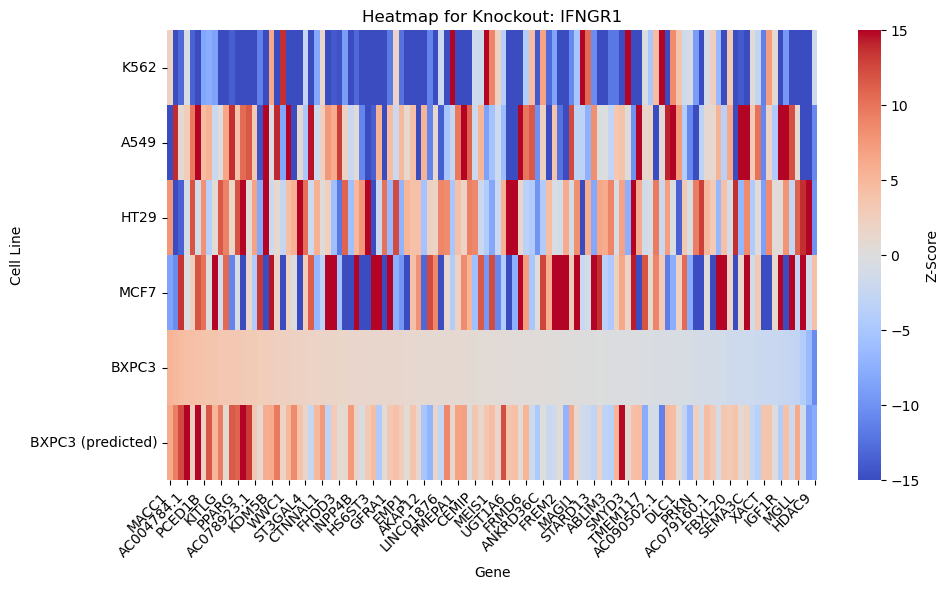

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


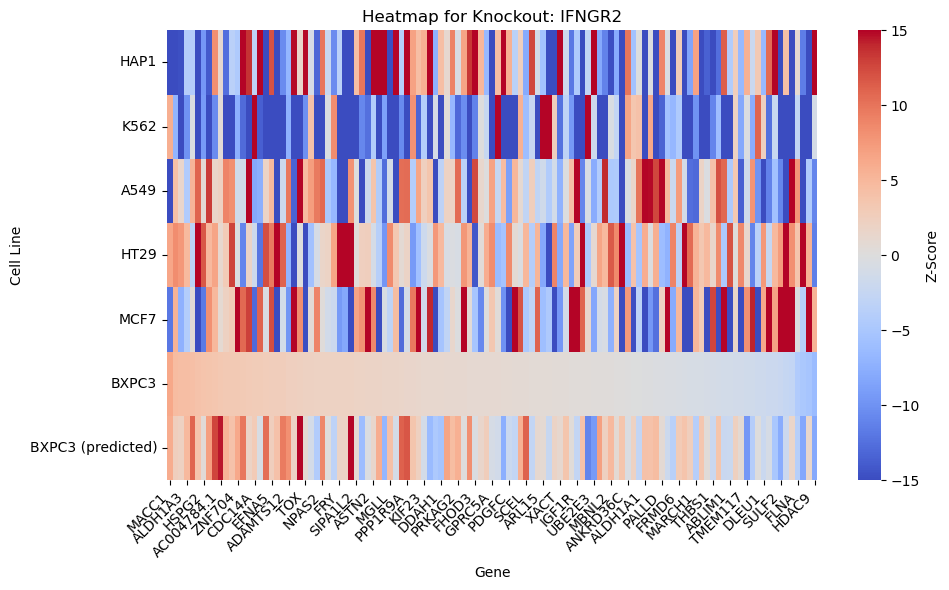

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


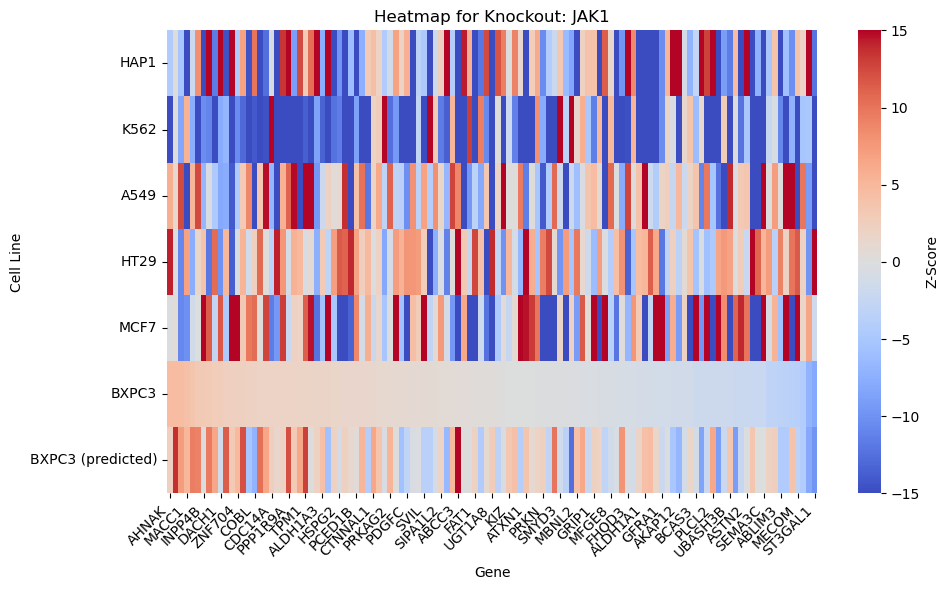

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


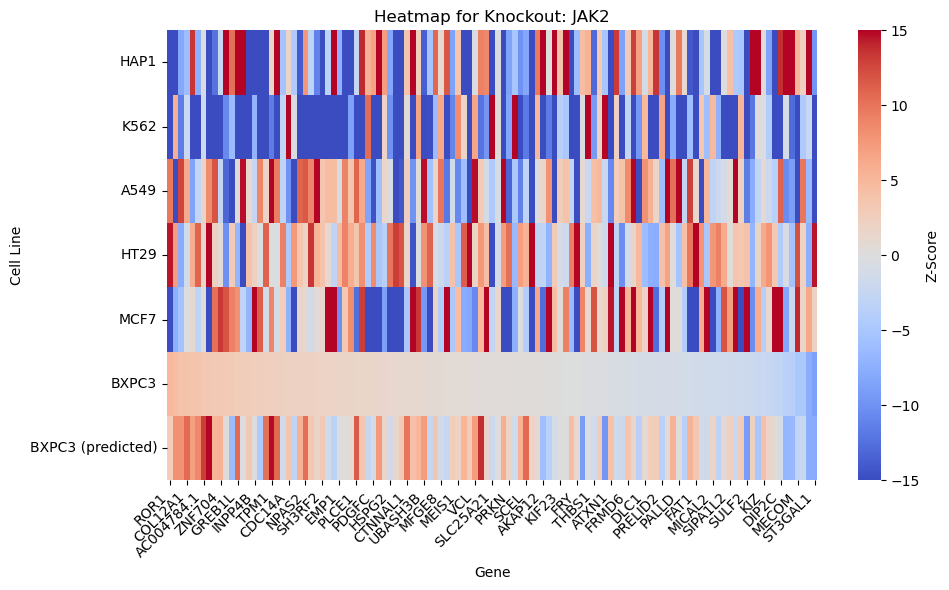

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


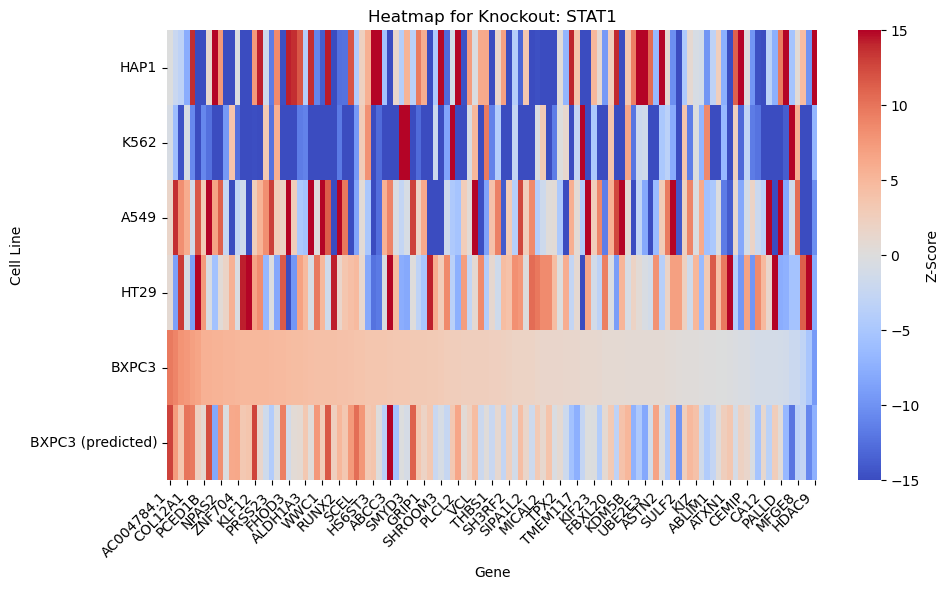

In [179]:
plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [180]:
df_selected = df_selected.drop(columns=['cell_line', 'zscore', 'program'])
df_predicted_heatmaps = df_predicted_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.216862              0.219750   
1   BXPC3 (predicted)      HAP1            -0.193107             -0.179886   
2   BXPC3 (predicted)      HT29             0.147005              0.166101   
3   BXPC3 (predicted)      K562            -0.171613             -0.136375   
4   BXPC3 (predicted)      MCF7            -0.182123             -0.213715   
5   BXPC3 (predicted)     BXPC3             0.463478              0.415929   

         MAE  
0   9.160316  
1  14.053772  
2   7.238430  
3  18.838289  
4  15.336244  
5   3.672091

In [181]:
IFNG_program1_up = df_present_in_all_ct.loc[df_present_in_all_ct['program'] == 'IFNG_program1_down']
IFNG_program1_up = IFNG_program1_up.rename(columns={'perturbation': 'knockout'}).drop(columns=['cellline'])
df_selected = df_zscores.merge(IFNG_program1_up, on=['pathway', 'gene', 'knockout'], how='inner').drop_duplicates()

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


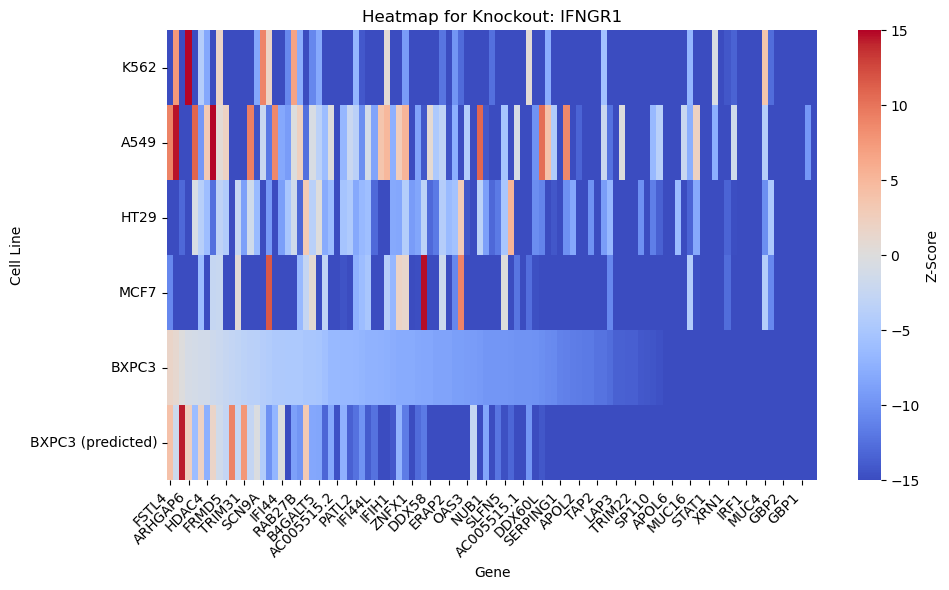

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


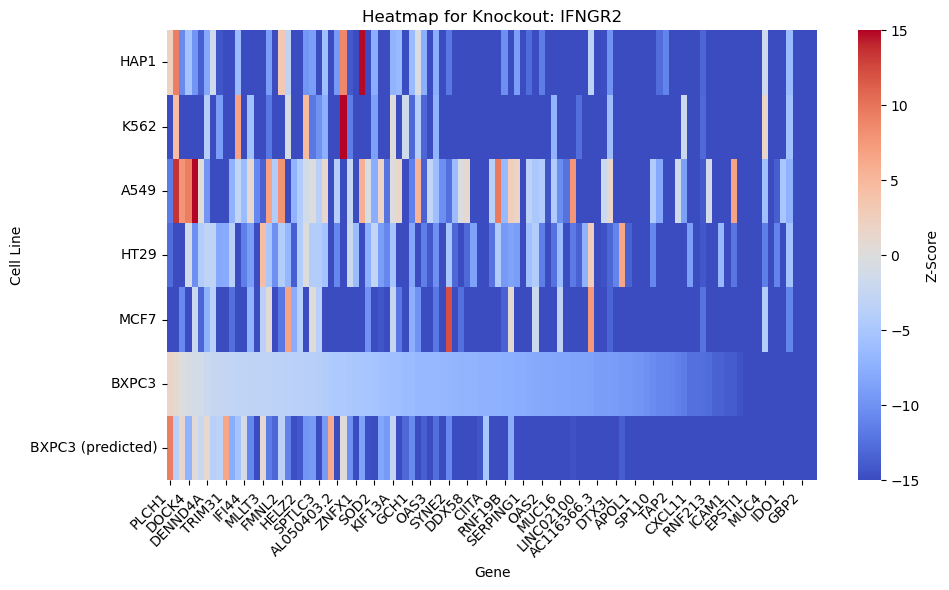

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


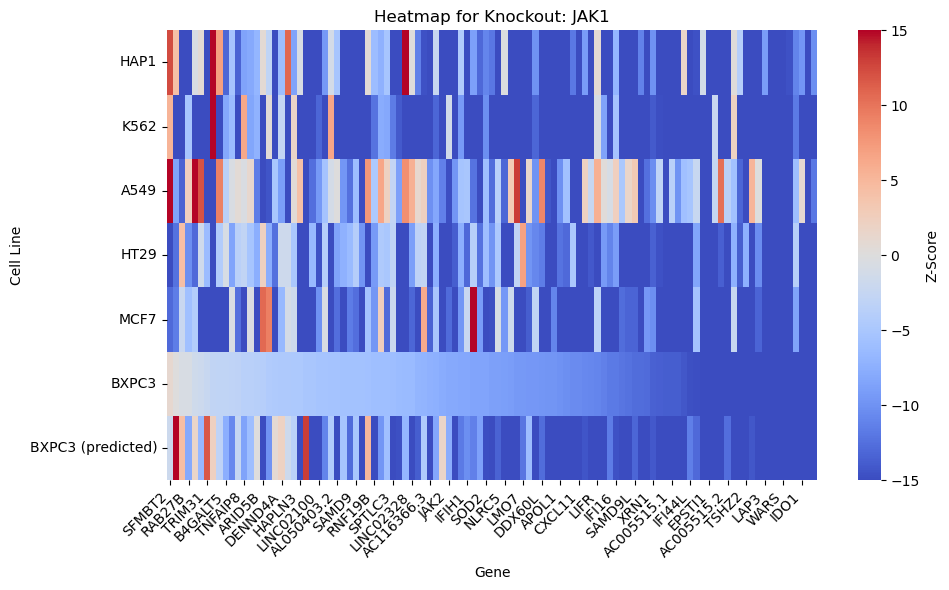

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


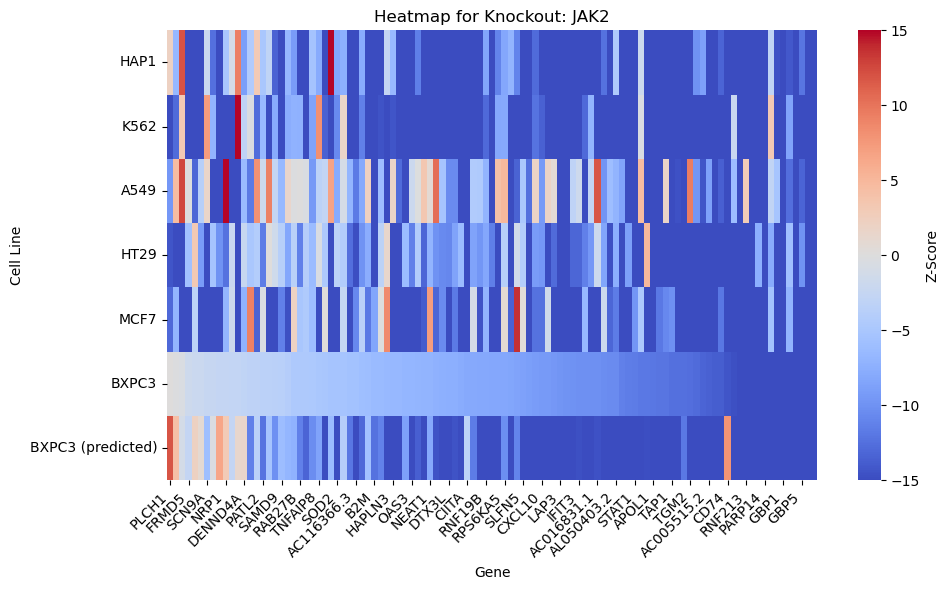

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


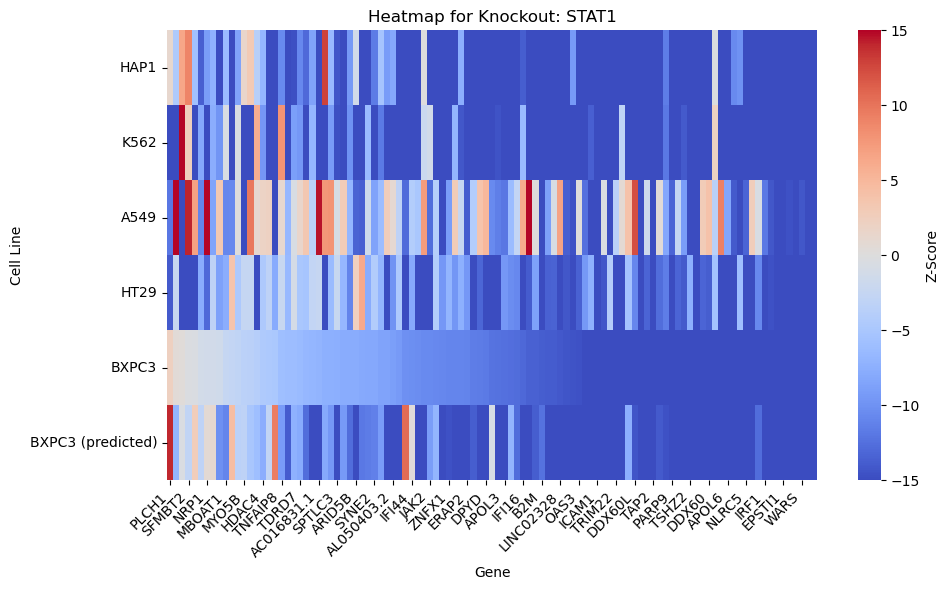

In [182]:
plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [183]:
df_selected = df_selected.drop(columns=['cell_line', 'zscore', 'program'])
df_predicted_heatmaps = df_predicted_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(df_selected, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.322329              0.317586   
1   BXPC3 (predicted)      HAP1             0.288766              0.373502   
2   BXPC3 (predicted)      HT29             0.280863              0.351145   
3   BXPC3 (predicted)      K562             0.161124              0.172827   
4   BXPC3 (predicted)      MCF7             0.324837              0.307274   
5   BXPC3 (predicted)     BXPC3             0.774513              0.769565   

         MAE  
0  16.656019  
1  15.811584  
2  13.212573  
3  19.136848  
4  14.461203  
5  12.140813

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


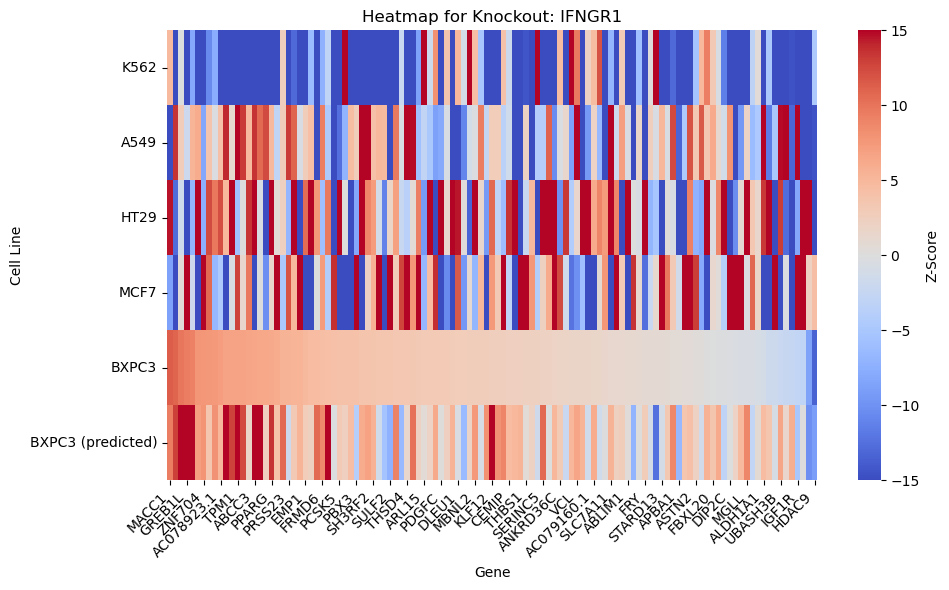

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


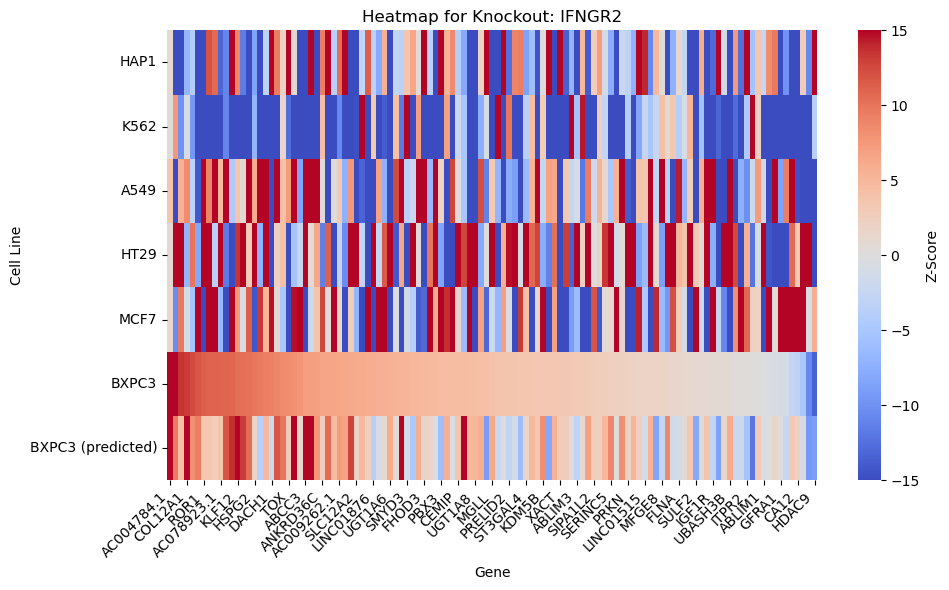

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


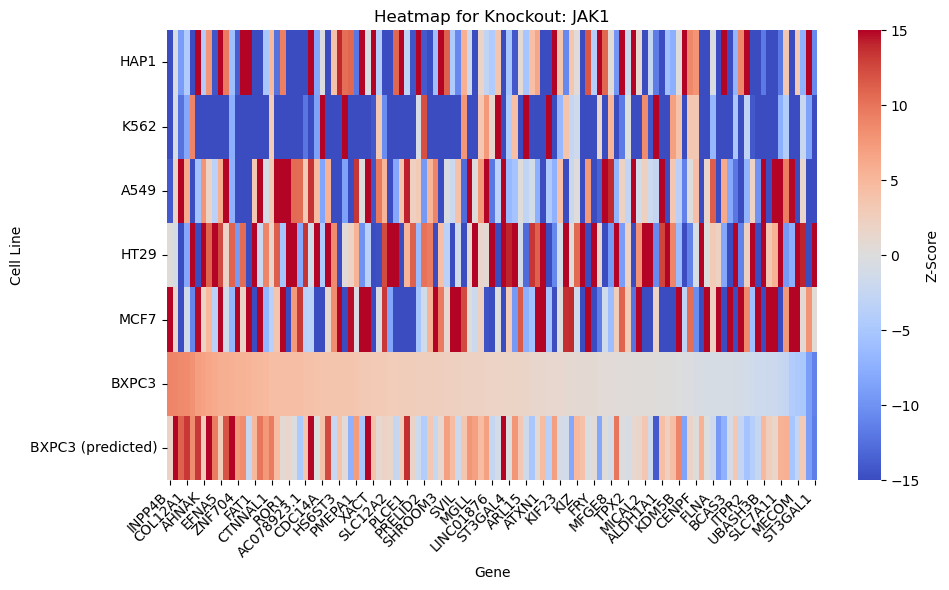

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


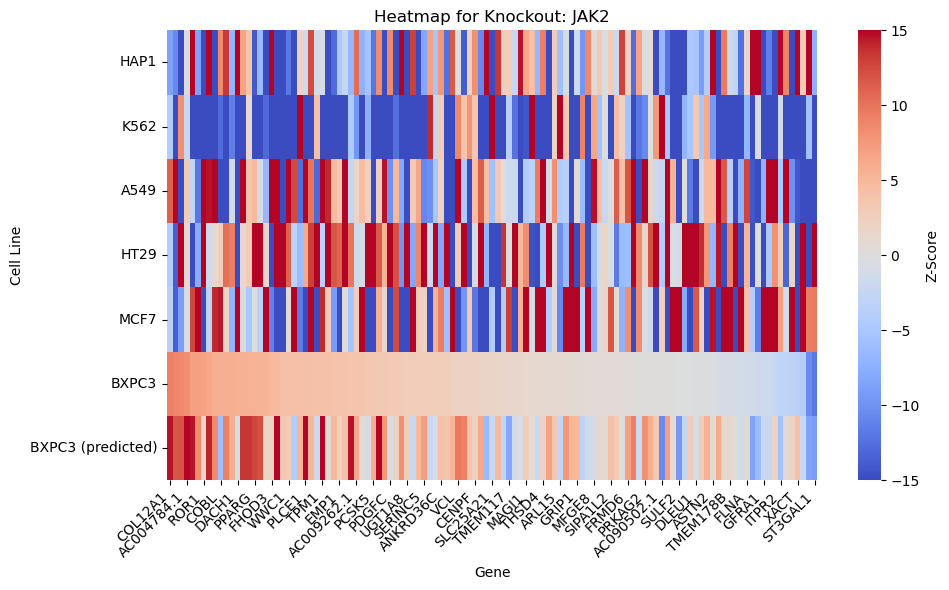

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


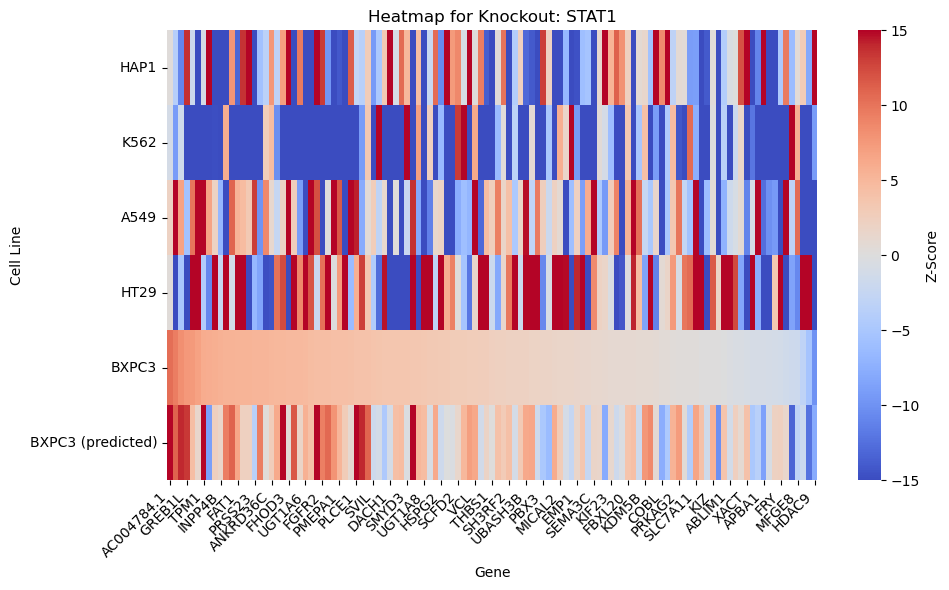

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


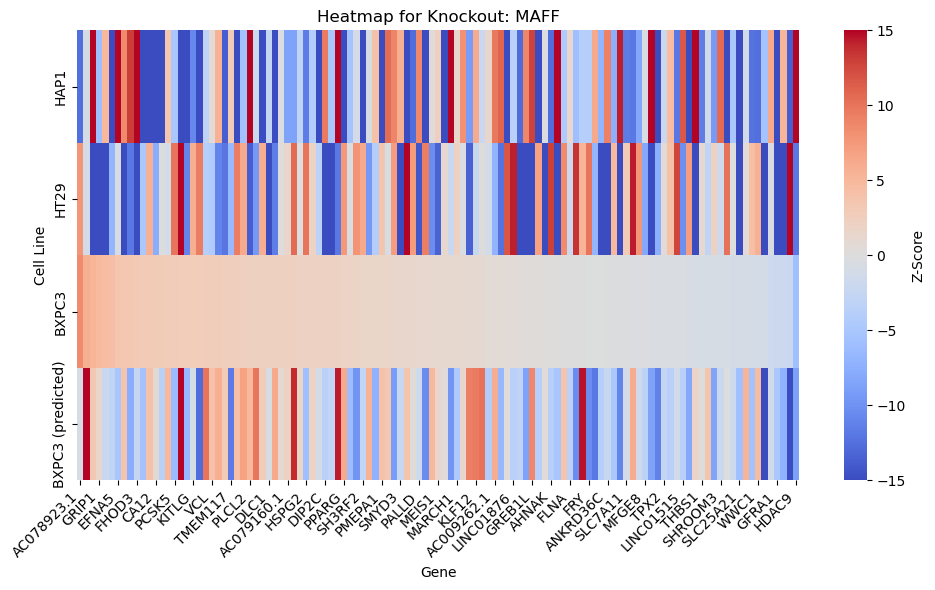

In [108]:
IFNG_program1_up = perturbation_programs.loc[perturbation_programs['program'] == 'IFNG_program1_up']

genes = IFNG_program1_up['gene'].unique().tolist()
knockouts = IFNG_program1_up['perturbation'].unique().tolist()
pathways = IFNG_program1_up['pathway'].unique().tolist()
cell_types = [*IFNG_program1_up['cellline'].unique(), 'BXPC3 (predicted)']

df_uc4 = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df_uc4, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [109]:
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.281251              0.274685   
1   BXPC3 (predicted)     BXPC3             0.507256              0.456383   
2   BXPC3 (predicted)      HAP1            -0.108871             -0.111492   
3   BXPC3 (predicted)      HT29             0.172655              0.198763   
4   BXPC3 (predicted)      K562            -0.101262             -0.060148   
5   BXPC3 (predicted)      MCF7            -0.189741             -0.200762   

         MAE  
0  11.929568  
1   4.465179  
2  15.989280  
3  14.054834  
4  24.909590  
5  19.409187

In [28]:
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.281251              0.274685   
1   BXPC3 (predicted)     BXPC3             0.507256              0.456383   
2   BXPC3 (predicted)      HAP1            -0.108871             -0.111492   
3   BXPC3 (predicted)      HT29             0.172655              0.198763   
4   BXPC3 (predicted)      K562            -0.101262             -0.060148   
5   BXPC3 (predicted)      MCF7            -0.189741             -0.200762   

         MAE  
0  11.929568  
1   4.465179  
2  15.989280  
3  14.054834  
4  24.909590  
5  19.409187

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


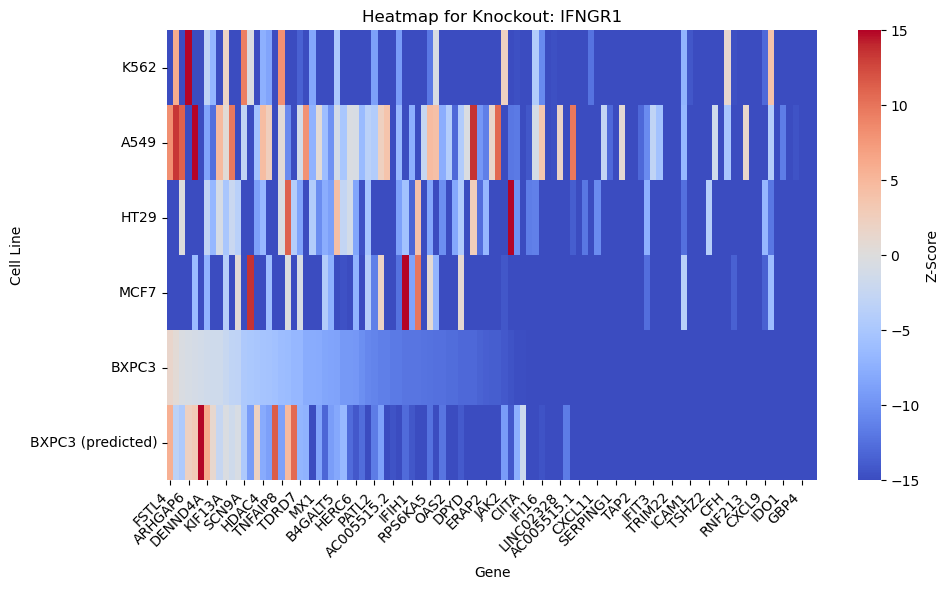

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


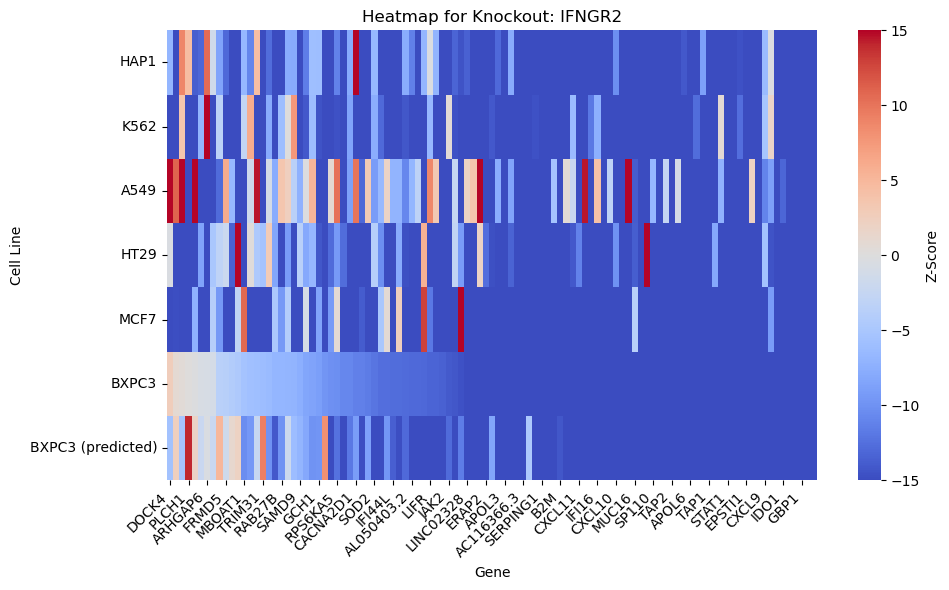

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


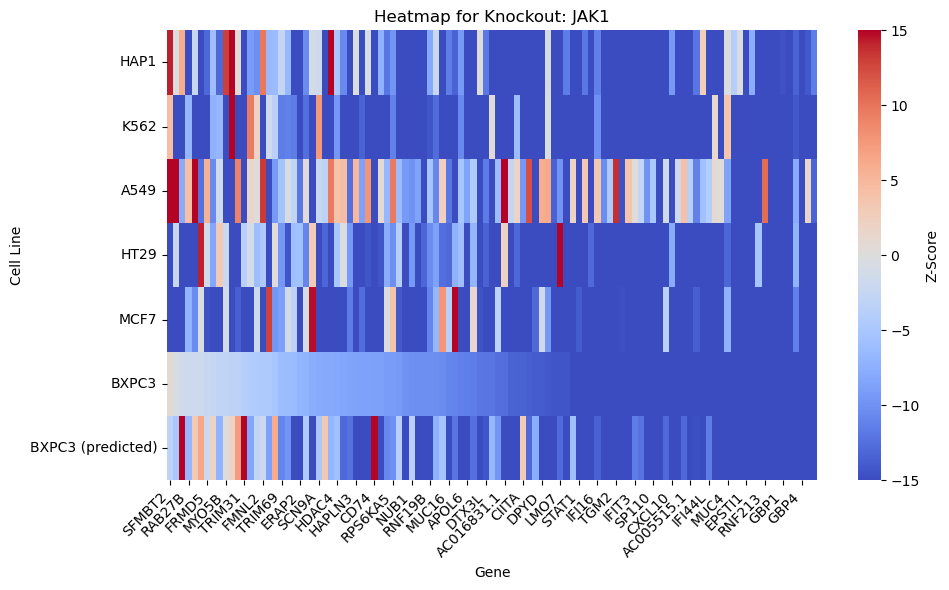

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


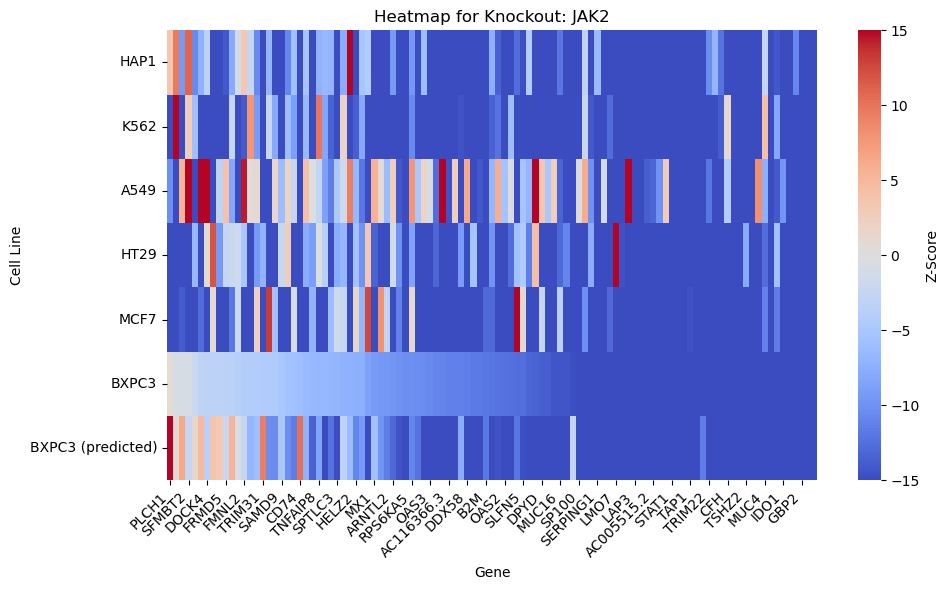

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


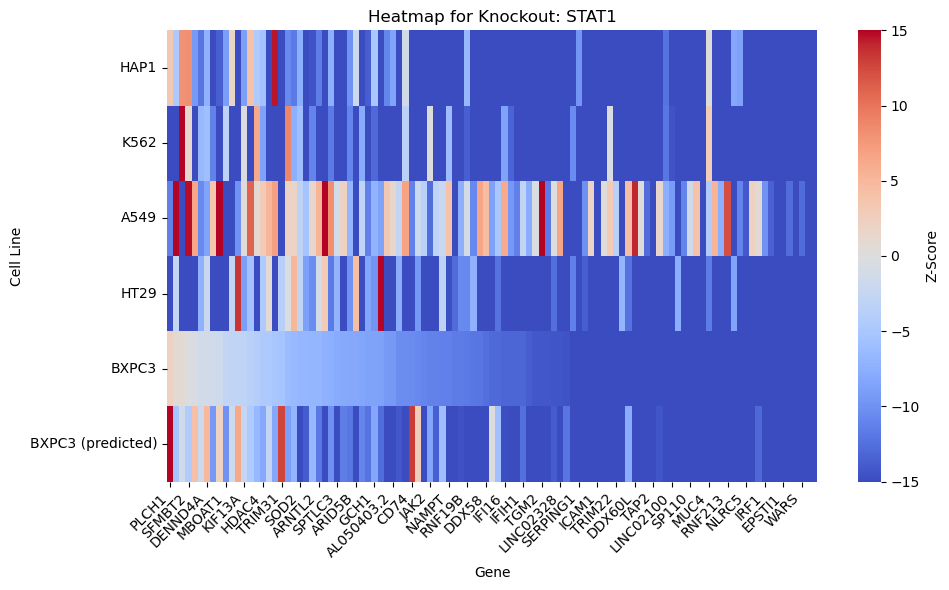

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


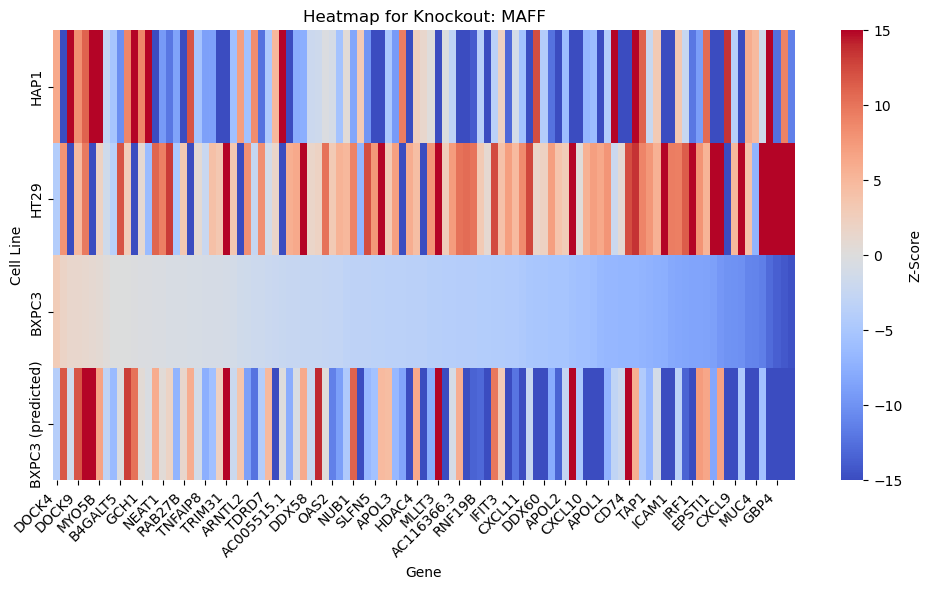

In [33]:
selected_program = perturbation_programs.loc[perturbation_programs['program'] == 'IFNG_program1_down']

genes = selected_program['gene'].unique().tolist()
knockouts = selected_program['perturbation'].unique().tolist()
pathways = selected_program['pathway'].unique().tolist()
cell_types = [*selected_program['cellline'].unique(), 'BXPC3 (predicted)']

df_selected = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [34]:
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.309811              0.311888   
1   BXPC3 (predicted)     BXPC3             0.805850              0.806232   
2   BXPC3 (predicted)      HAP1             0.267432              0.367825   
3   BXPC3 (predicted)      HT29             0.321721              0.377798   
4   BXPC3 (predicted)      K562             0.137339              0.153749   
5   BXPC3 (predicted)      MCF7             0.334445              0.317483   

         MAE  
0  18.074438  
1   9.845134  
2  17.780851  
3  15.964209  
4  21.948366  
5  17.476933

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


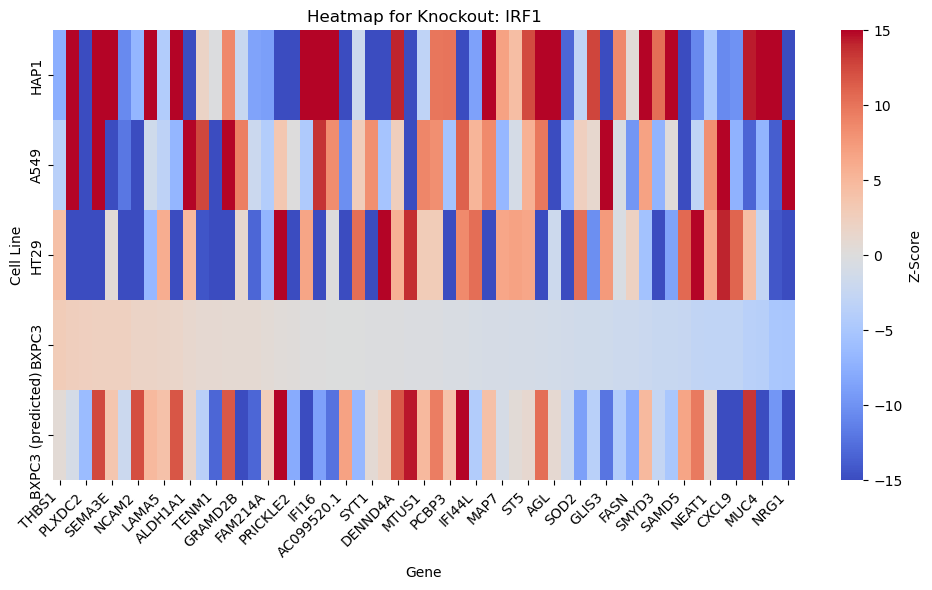

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


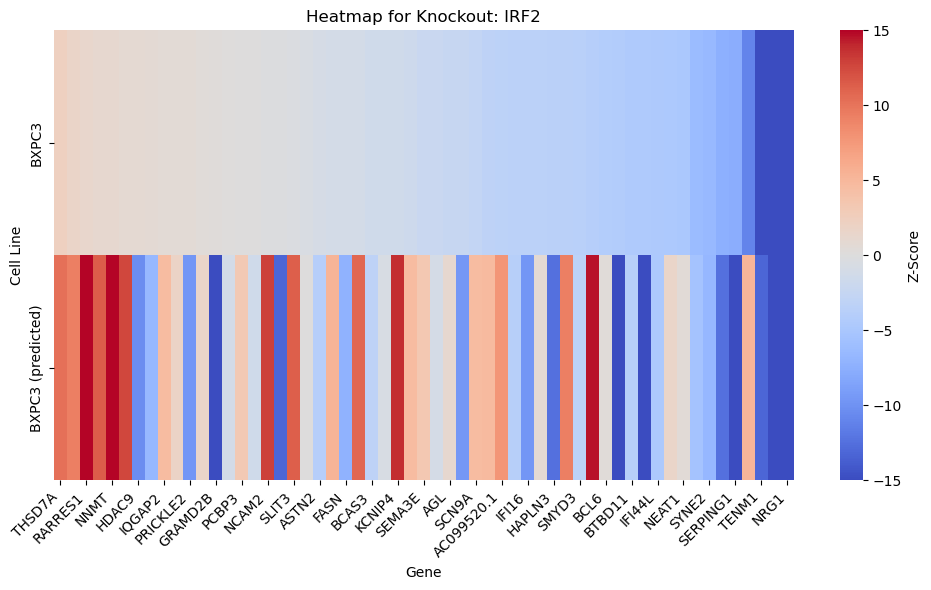

In [35]:
selected_program = perturbation_programs.loc[perturbation_programs['program'] == 'IFNG_program2_up']

genes = selected_program['gene'].unique().tolist()
knockouts = selected_program['perturbation'].unique().tolist()
pathways = selected_program['pathway'].unique().tolist()
cell_types = [*selected_program['cellline'].unique(), 'BXPC3 (predicted)']

df_selected = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [36]:
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549            -0.089648             -0.046863   
1   BXPC3 (predicted)     BXPC3             0.424522              0.307928   
2   BXPC3 (predicted)      HAP1            -0.073438              0.000065   
3   BXPC3 (predicted)      HT29            -0.041227              0.002787   
4   BXPC3 (predicted)      MCF7            -0.042646             -0.096254   

         MAE  
0  17.999634  
1  10.258389  
2  19.500443  
3  17.843956  
4  26.010948

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


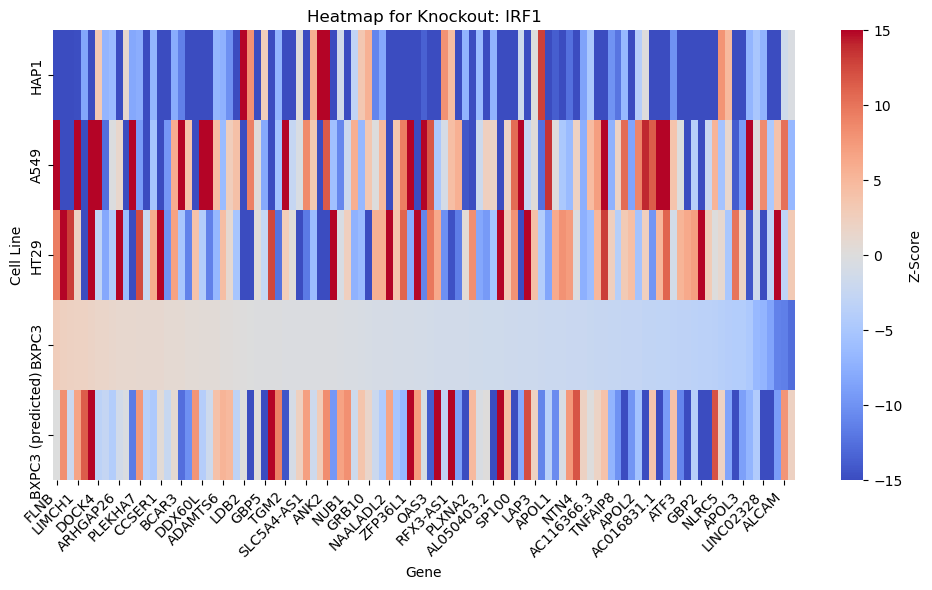

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


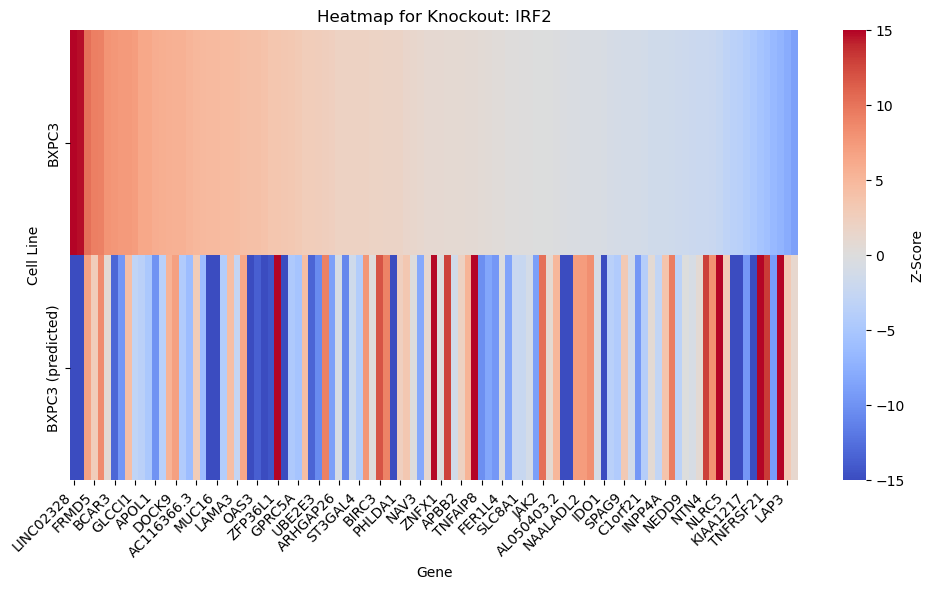

In [43]:
selected_program = perturbation_programs.loc[perturbation_programs['program'] == 'IFNG_program2_down']

genes = selected_program['gene'].unique().tolist()
knockouts = selected_program['perturbation'].unique().tolist()
pathways = selected_program['pathway'].unique().tolist()
cell_types = [*selected_program['cellline'].unique(), 'BXPC3 (predicted)']

df_selected = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [44]:
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549            -0.045344             -0.165364   
1   BXPC3 (predicted)     BXPC3             0.013850              0.019592   
2   BXPC3 (predicted)      HAP1            -0.090542             -0.027567   
3   BXPC3 (predicted)      HT29             0.061946              0.028860   
4   BXPC3 (predicted)      MCF7             0.213730              0.197672   

         MAE  
0  17.701752  
1  11.422181  
2  22.509207  
3  14.698773  
4  20.547987

/lustre/groups/ml01/workspace/lea.zimmermann/software/miniconda3/envs/cfp2/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


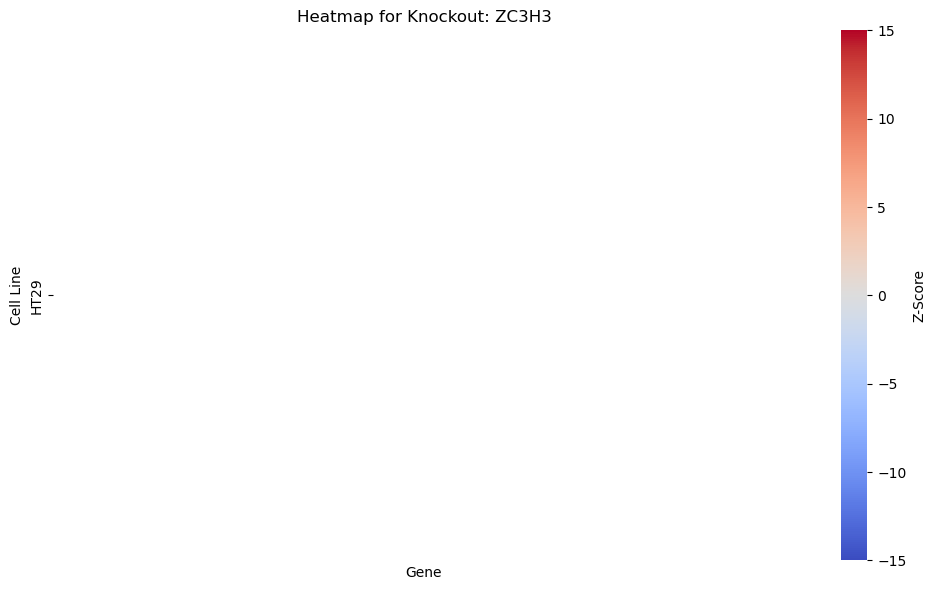

In [45]:
selected_program = perturbation_programs.loc[perturbation_programs['program'] == 'IFNG_program3_up']

genes = selected_program['gene'].unique().tolist()
knockouts = selected_program['perturbation'].unique().tolist()
pathways = selected_program['pathway'].unique().tolist()
cell_types = [*selected_program['cellline'].unique(), 'BXPC3 (predicted)']

df_selected = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [46]:
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

Empty DataFrame
Columns: []
Index: []

In [49]:
selected_program = perturbation_programs.loc[perturbation_programs['program'] == 'IFNG_program3_down']

genes = selected_program['gene'].unique().tolist()
knockouts = selected_program['perturbation'].unique().tolist()
pathways = selected_program['pathway'].unique().tolist()
cell_types = [*selected_program['cellline'].unique(), 'BXPC3 (predicted)']

df_selected = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)

In [50]:
df_predicted_heatmaps = df_predicted_filtered.query('gene in @genes and knockout in @knockouts')
df_ground_truth_heatmaps = df_ground_truth_filtered.query('gene in @genes and knockout in @knockouts')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

Empty DataFrame
Columns: []
Index: []

## calculate similarities accross all programs
Only conditions are selected that occur in all cell lines.

In [95]:
# Count unique cell lines per (gene, pathway, perturbation) combination
cell_line_counts = (
    filtered_df.groupby(['gene', 'pathway', 'perturbation', 'program'])['cellline']
    .nunique()
    .reset_index(name='cellline_count')
)

# Filter only those with at least 2 unique cell lines
valid_combinations = cell_line_counts[cell_line_counts['cellline_count'] >= 6]

# Merge back to retain only valid rows
present_in_all_celllines_df = filtered_df.merge(valid_combinations[['gene', 'pathway', 'perturbation', 'program']], 
                                on=['gene', 'pathway', 'perturbation', 'program'], 
                                how='inner')

In [108]:
valid_combinations = present_in_all_celllines_df[['pathway', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = valid_combinations.rename(columns={'perturbation': 'knockout'})
df_predicted_heatmaps = df_predicted_filtered.merge(valid_combinations, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(valid_combinations, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

NameError: name 'present_in_all_celllines_df' is not defined

## filter for BXPC3 and IFNG

In [116]:
present_in_BXPC3 = filtered_df.query('cellline == "BXPC3" and pathway == "IFNG"')[['pathway', 'program', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = set(zip(present_in_BXPC3['gene'], present_in_BXPC3['perturbation'], present_in_BXPC3['pathway'], present_in_BXPC3['program']))

filtered_df = perturbation_programs[
    perturbation_programs[['gene', 'perturbation', 'pathway', 'program']].apply(tuple, axis=1).isin(valid_combinations)
]

cell_line_counts = (
    filtered_df.groupby(['gene', 'pathway', 'perturbation', 'program'])['cellline']
    .nunique()
    .reset_index(name='cellline_count')
)

# Filter only those with at least 2 unique cell lines
valid_combinations = cell_line_counts[cell_line_counts['cellline_count'] >= 6] # TODO: should we choose another threshold?

# Merge back to retain only valid rows
filtered_df = filtered_df.merge(valid_combinations[['gene', 'pathway', 'perturbation', 'program']], 
                                on=['gene', 'pathway', 'perturbation', 'program'], 
                                how='inner')

valid_combinations = filtered_df[['pathway', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = valid_combinations.rename(columns={'perturbation': 'knockout'})

In [117]:
df_predicted_heatmaps = df_predicted_filtered.merge(valid_combinations, on=['pathway', 'gene', 'knockout'], how='inner')
df_ground_truth_heatmaps = df_ground_truth_filtered.merge(valid_combinations, on=['pathway', 'gene', 'knockout'], how='inner')

df_results_heatmaps = calculate_similarities(df_predicted_heatmaps, df_ground_truth_heatmaps)
df_results_heatmaps

cell_line_predicted cell_line  pearson_correlation  spearman_correlation  \
0   BXPC3 (predicted)      A549             0.356682              0.346787   
1   BXPC3 (predicted)      HAP1             0.393697              0.401893   
2   BXPC3 (predicted)      HT29             0.489304              0.557631   
3   BXPC3 (predicted)      K562             0.223669              0.171225   
4   BXPC3 (predicted)      MCF7             0.415134              0.426385   
5   BXPC3 (predicted)     BXPC3             0.888681              0.840409   

         MAE  
0  14.862349  
1  16.871572  
2  14.975746  
3  23.496279  
4  18.486977  
5   6.664983

In [ ]:
valid_combinations = present_in_all_celllines_df[['pathway', 'gene', 'perturbation']].drop_duplicates()
valid_combinations = valid_combinations.rename(columns={'perturbation': 'knockout'})
df_predicted_heatmaps = df_predicted_filtered.merge(valid_combinations, on=['pathway', 'gene', 'knockout'], how='inner')

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


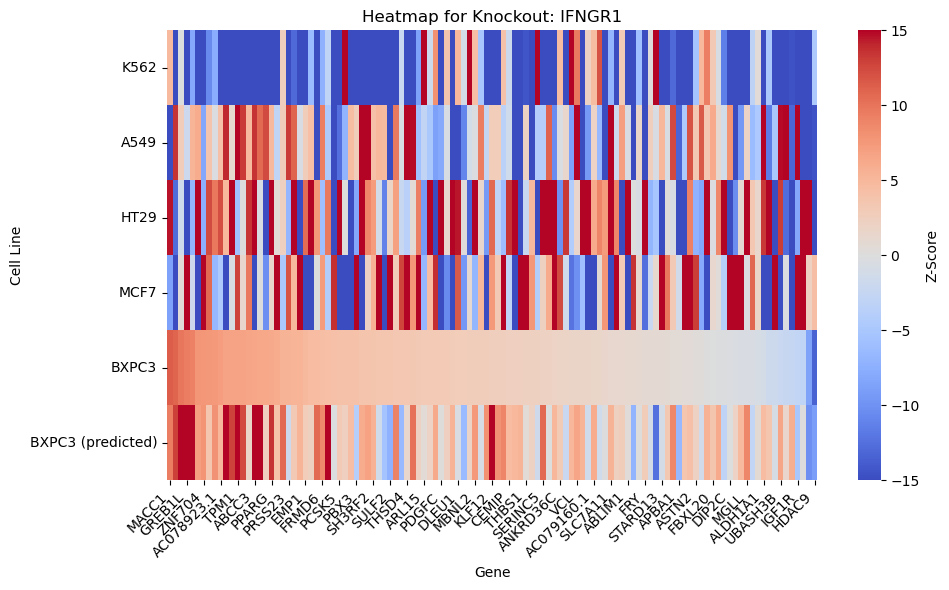

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


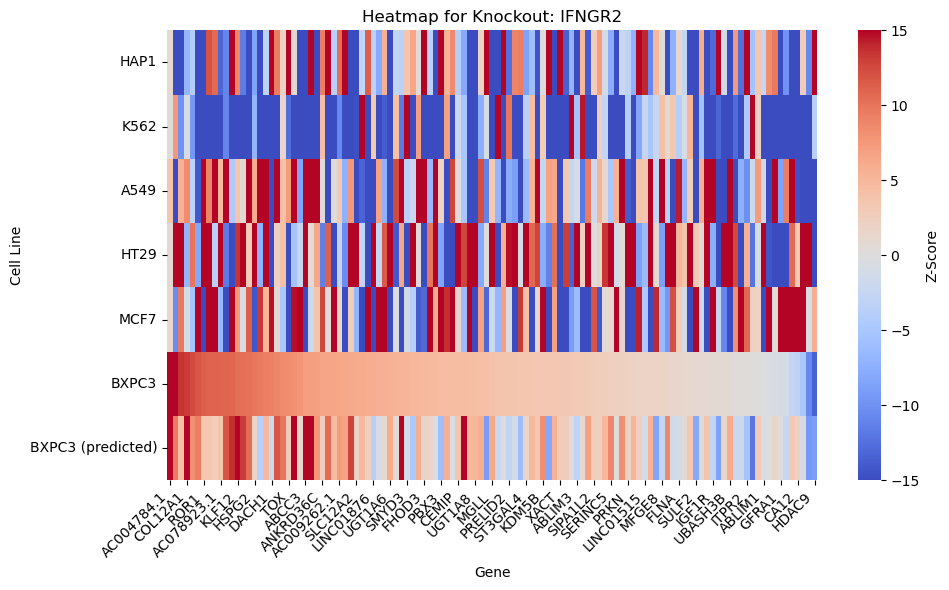

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


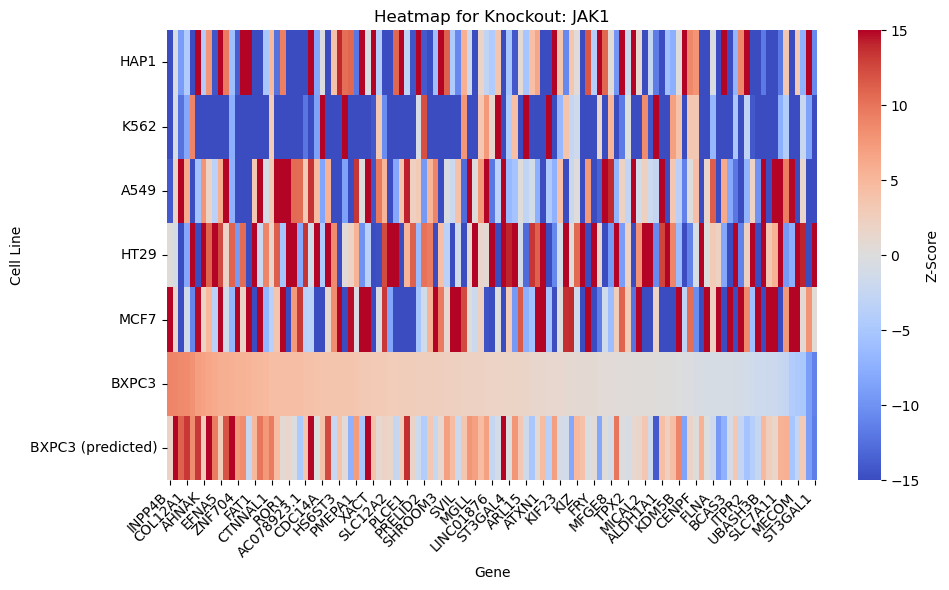

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


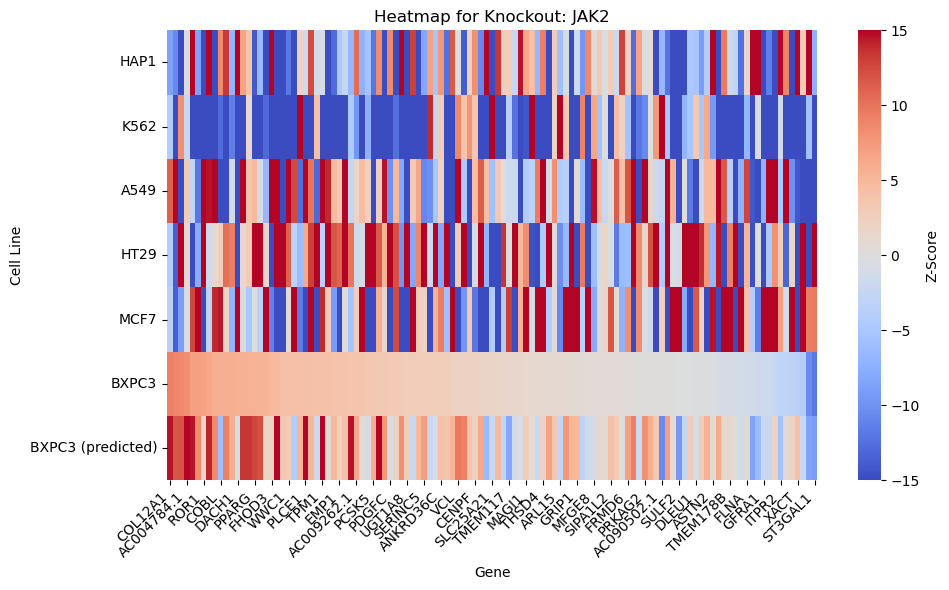

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


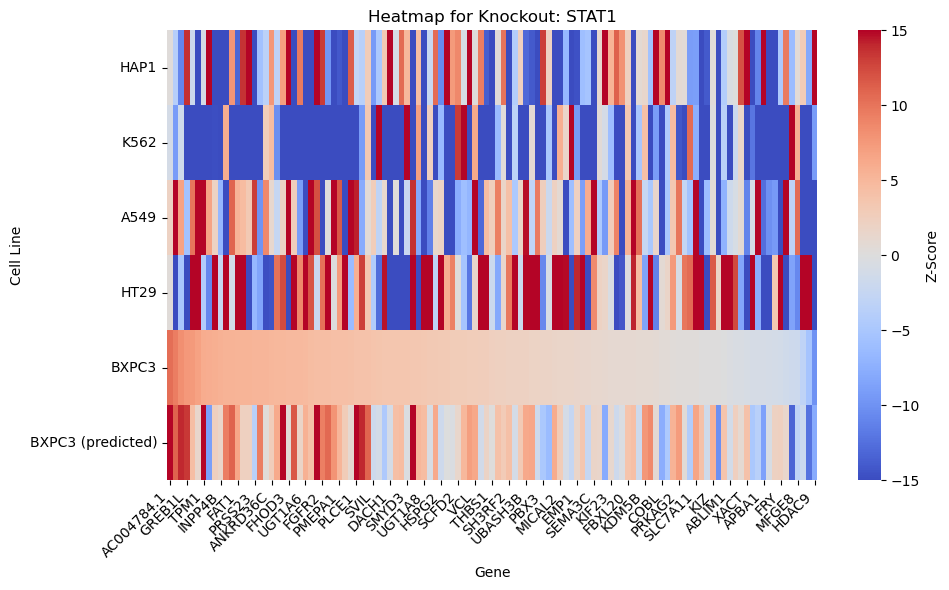

/ictstr01/home/icb/lea.zimmermann/projects/ot_pert_reproducibility/evaluation/evaluate_downstream/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knockout_df['cell_line'] = pd.Categorical(knockout_df['cell_line'], categories=cell_line_order, ordered=True)


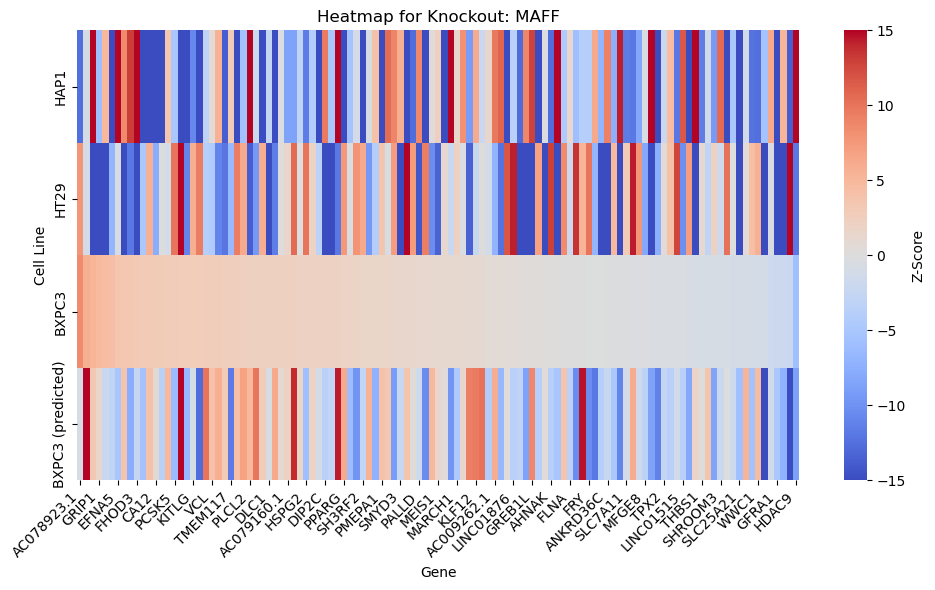

In [119]:
selected_program = perturbation_programs.loc[perturbation_programs['program'] == 'IFNG_program1_up']

genes = selected_program['gene'].unique().tolist()
knockouts = selected_program['perturbation'].unique().tolist()
pathways = selected_program['pathway'].unique().tolist()
cell_types = [*selected_program['cellline'].unique(), 'BXPC3 (predicted)']

df_selected = df_zscores[
    df_zscores['knockout'].isin(knockouts) &
    df_zscores['pathway'].isin(pathways) &
    df_zscores['cell_line'].isin(cell_types) &
    df_zscores['gene'].isin(genes)
]

plot_heatmaps_by_knockout_ordered(df_selected, vmin=-15, vmax=15, cell_line_order=cell_line_order)